# Предсказание температуры сплава

**Описание проекта:** металлургический комбинат «Стальная птица» внедряет модель машинного обучения, имитирующую технологический процесс, способную предсказать температуру сплава с целью оптимизации потребления электроэнергии.

Цель работы: оптимизация потребления электроэнергии с помощью предсказания разработанной модели.

**Ход работы:**

1 Загрузка данных и первичный анализ.

2 Исследовательский анализ данных.
* Анализ датасетов и обработка данных;
* Объединение датасетов по ключу;
* Исследовательский анализ.

3 Обучение модели.
* Разделение на тренировочную и тестовую выборки;
* Обучение моделей и проверка результатов.

4 Тестирование модели и анализ важности признаков.
* Проверка модели на тестовых данных;
* Анализ важности признаков.

**Общий вывод:** анализ полученной модели и выводы по проделанной работе, возможные рекомендации.

Требования заказчика: 
1. таргет - последняя температура в партии;
2. пригодной для предсказания является партия с измерением температур не менее двух раз;
3. целевое значение метрики: МАЕ < 6.8;
4. разработка не менее двух моделей с подбором не менее двух гиперпараметров;
5. разбивка на тренировочную и тестовую выборки с соотношением 3:1.

**Загрузка библиотек**

In [1]:
!pip install phik -q
!pip install optuna -q
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

**Импорт библиотек**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgbm
import shap
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import early_stopping

**Константы**

In [3]:
RANDOM_STATE = 280725
TEST_SIZE = 0.25

## Загрузка данных и первичный анализ

### Загрузка

In [4]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_arc_new.csv')
    data_bulk = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_bulk_new.csv')
    data_bulk_time = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_bulk_time_new.csv')
    data_gas = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_gas_new.csv')
    data_temp = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_temp_new.csv')
    data_wire = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_wire_new.csv')
    data_wire_time = pd.read_csv('F:\\Учеба яндекс\\projects\\final_project\\data_wire_time_new.csv')

### Первичный анализ

In [5]:
def first_look(df):
    df.info()
    return display(df.describe(),df.head(10))

**Рассмотрим данные об электродах**

In [6]:
first_look(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Датасет имеет 14876 строк, для некоторых строк значение ключа повторяется, что говорит о том, что эти строки соответствуют разным итерациям обработки сплава, требуется приведение наименования столбцов к "змеиному языку", заметна аномалия в столбце с реактивной мощностью, пропуски отсутствуют.

**Рассмотрим данные о подаче сыпучих материалов**

In [7]:
first_look(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Датасет имеет 3129 строк, требуется приведение наименования столбцов к "змеиному языку", столбцы содержат пропуски в соответствии с лигирующими материалами: если материал не добавлялся - значение пропущено.

**Рассмотрим данные о времени подачи сыпучих материалов**

In [8]:
first_look(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Датасет имеет 3129 строк, требуется приведение наименования столбцов к "змеиному языку", количество ненулевых значений совпадает с аналогичным для датасета с объемом добавляемых в сплав лигирующих материалов. Однако само по себе время подачи материалов не может повлиять на физико-химические свойства стали, коей является температура сплава. Необходимо оценить необходимость включения данного признака в дальнейший анализ.

**Рассмотрим данные о продувке сплава газом**

In [9]:
first_look(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Датасет имеет 3239 строк, требуется приведение наименования столбцов к "змеиному языку", на первый взгляд выбивающиеся значения отсутствуют, пропусков нет.

**Рассмотрим данные об измерениях температуры**

In [10]:
first_look(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Датасет имеет 18092 строки, для некоторых строк значение ключа повторяется, что говорит о том, что эти строки соответствуют разным итерациям обработки сплава, требуется приведение наименования столбцов к "змеиному языку", можно заметить аномалии в столбце "температура".

**Рассмотрим данные о легировании проволочными материалами**

In [11]:
first_look(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет имеет 3081 строку, требуется приведение наименования столбцов к "змеиному языку", столбцы содержат пропуски в соответствии с лигирующими материалами: если материал не добавлялся - значение пропущено.

**Рассмотрим данные о времени добавки проволочных материалов**

In [12]:
first_look(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет имеет 3081 строку, требуется приведение наименования столбцов к "змеиному языку", столбцы содержат пропуски в соответствии с лигирующими материалами: если материал не добавлялся - значение пропущено.

**Вывод:** выполнена загрузка и первичный анализ данных. На первый взгляд, данные чистые, присутствуют пропуски, которые можно объяснить большой вариативностью марок стали в номенклатуре металлургического комбината «Стальная птица», присутствуют выбросы, которые будут обработаны в следующем разделе работы.

## Исследовательский анализ данных

Напишем функцию для приведения столбца к формату datetime:

In [13]:
def columns_to_date(df, column_list):
    for column in column_list:
        df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d %H:%M:%S')

Напишем функцию для анализа числовых признаков

In [14]:
def num_feature(data):
    display(data.describe())
    data.plot(kind = 'box', grid = True, figsize = (9,7))
    plt.title(f'Диаграмма размаха {data.name}', size = 15)
    plt.xlabel(data.name, size = 12)
    plt.show()
    data.hist(bins = 10, figsize = (9,7), edgecolor='black')
    plt.title(f'Гистограмма {data.name}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(data.name, size = 12)
    plt.show()

Напишем функцию для анализа граничных значений в столбце

In [15]:
def upper_and_lower_limits(df, column):
    upper_lim = np.percentile(df[column], 99.5)
    lower_lim = np.percentile(df[column], 0.5)
    display(f'99% значений столбца {column} лежат в диапазоне ' \
            f'{lower_lim:.2f} и {upper_lim:.2f}')
    display(
        f'Строки с {column} больше максимального', 
        df[df[column] > upper_lim].sort_values(by = column, ascending = False).head(),
        f'Строки с {column} меньше минимального',
        df[df[column] < lower_lim].sort_values(by = column).head())

Напишем функцию для анализа граничных значений столбцов с датой

In [16]:
def upper_and_lower_limits_of_time(df, material, num_cols):
    upper_df = pd.DataFrame()
    lower_df = pd.DataFrame()
    for i in range(1,num_cols + 1):
        upper_df[material+f'_{i}'] = df[material+f'_{i}'].sort_values(ascending = False).head().values
        lower_df[material+f'_{i}'] = df[material+f'_{i}'].sort_values().head().values
    return upper_df, lower_df

### Анализ датасетов и обработка данных

#### Данные об электродах

**Переименование столбцов**

In [17]:
data_arc.columns = ['key', 'beg_of_heat', 'end_of_heat', 'act_sup', 'react_sup']

**Приведение к нужному формату**

In [18]:
columns_to_date(data_arc, ['beg_of_heat', 'end_of_heat'])

**Исследовательский анализ**

###### Активная мощность

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: act_sup, dtype: float64

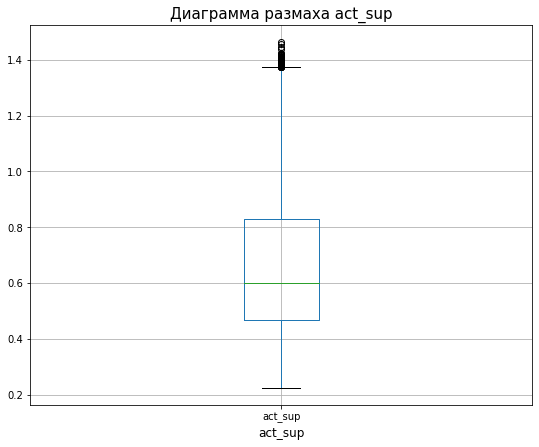

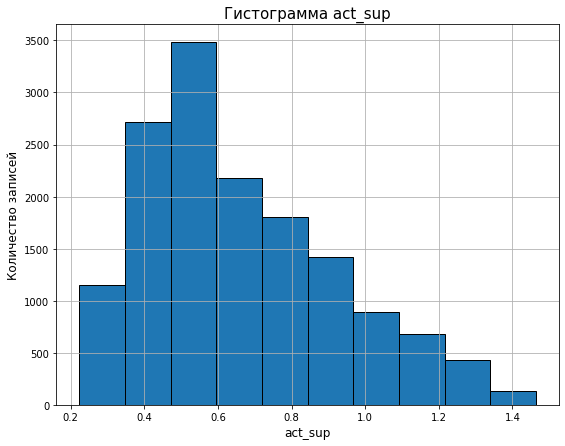

In [19]:
num_feature(data_arc['act_sup'])

In [20]:
upper_and_lower_limits(data_arc, 'act_sup')

'99% значений столбца act_sup лежат в диапазоне 0.26 и 1.37'

'Строки с act_sup больше максимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup
8382,1823,2019-07-10 05:03:56,2019-07-10 05:05:12,1.463773,0.988148
11148,2427,2019-08-07 21:48:20,2019-08-07 21:52:36,1.458773,1.067576
4190,902,2019-06-07 08:25:25,2019-06-07 08:26:52,1.444904,1.059033
1844,400,2019-05-18 21:19:27,2019-05-18 21:21:44,1.437648,0.984532
3914,845,2019-06-05 10:26:50,2019-06-05 10:29:04,1.426122,1.009663


'Строки с act_sup меньше минимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup
14852,3237,2019-09-06 11:41:17,2019-09-06 11:45:12,0.223120,0.172958
13870,3010,2019-08-29 16:22:43,2019-08-29 16:24:57,0.223238,0.177071
8811,1917,2019-07-19 06:09:51,2019-07-19 06:10:54,0.223895,0.181544
4523,974,2019-06-10 03:26:00,2019-06-10 03:28:27,0.228238,0.188686
3382,733,2019-05-31 23:54:36,2019-05-31 23:58:30,0.228238,0.171438


Распределение активной мощности стремится к нормальному со средним 0.66. 99% значений столбца act_sup лежат в диапазоне 0.26 и 1.37. Осмотр выбивающихся значений не показал четких закономерностей. Нельзя однозначно утверждать, что такие данные не являются реальными.

###### Реактивная мощность

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: react_sup, dtype: float64

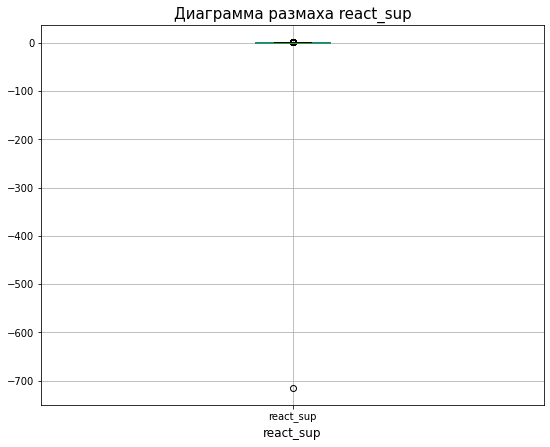

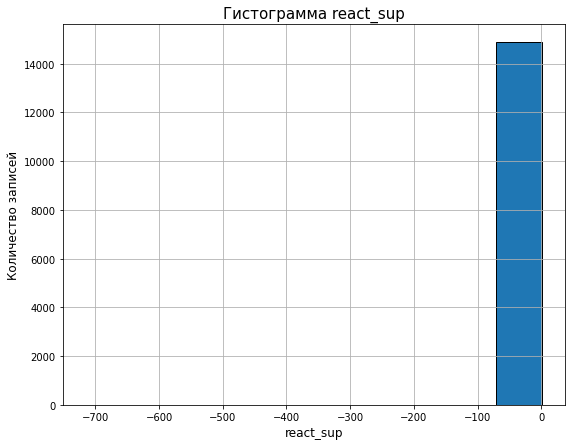

In [21]:
num_feature(data_arc['react_sup'])

Проверим аномальное наблюдение

In [22]:
data_arc[data_arc['react_sup'] < 0]

,key,beg_of_heat,end_of_heat,act_sup,react_sup
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Выполним осмотр данной партии

In [23]:
data_arc.query('key == 2116')

,key,beg_of_heat,end_of_heat,act_sup,react_sup
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Можно заметить наличие корреляции между активной и реактивной мощностью. Учитывая, что данные характеристики зависят от технологических особенностей производства, можно предположить, что между измеренями не может быть изменения характера данной зависимости.

С помощью линейной экстраполяции мощностей вычислим реактивную мощность для наблюдения с аномалией

In [24]:
data_arc.loc[9780,'react_sup'] =  data_arc.loc[9781,'react_sup'] + \
    (data_arc.loc[9778,'react_sup'] - data_arc.loc[9779,'react_sup'])/ \
        (data_arc.loc[9778,'act_sup'] - data_arc.loc[9779,'act_sup'])* \
    (data_arc.loc[9780,'act_sup'] - data_arc.loc[9781,'act_sup'])
data_arc.iloc[9780]

key                           2116
beg_of_heat    2019-07-28 02:22:08
end_of_heat    2019-07-28 02:23:57
act_sup                   0.705344
react_sup                 0.601553
Name: 9780, dtype: object

Заново проанализируем реативную мощность

count    14876.000000
mean         0.487123
std          0.197608
min          0.153777
25%          0.337192
50%          0.441667
75%          0.608201
max          1.270284
Name: react_sup, dtype: float64

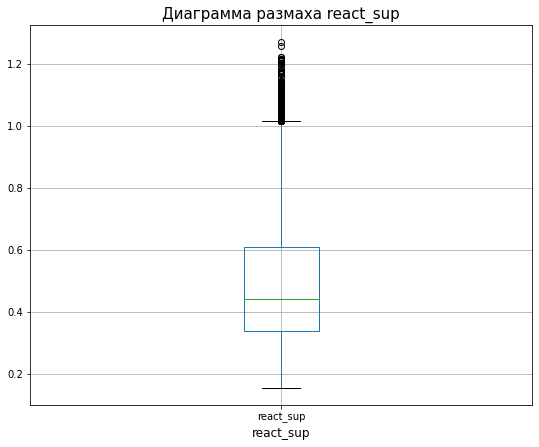

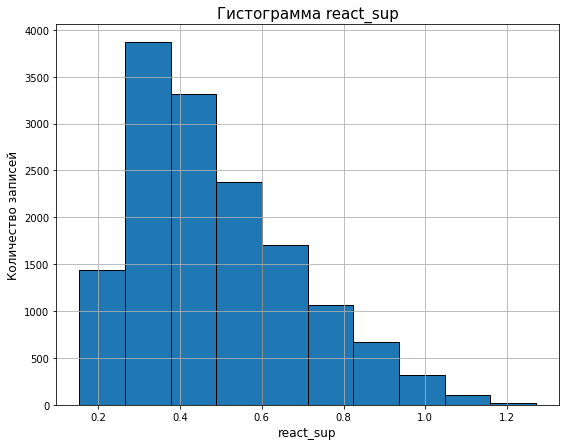

In [25]:
num_feature(data_arc['react_sup'])

In [26]:
upper_and_lower_limits(data_arc, 'react_sup')

'99% значений столбца react_sup лежат в диапазоне 0.18 и 1.08'

'Строки с react_sup больше максимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup
2591,564,2019-05-24 23:02:49,2019-05-24 23:05:31,1.410455,1.270284
3452,748,2019-06-01 16:24:02,2019-06-01 16:26:16,1.374768,1.258628
8116,1759,2019-07-07 22:52:07,2019-07-07 22:56:35,1.381885,1.223063
14115,3069,2019-08-31 20:02:33,2019-08-31 20:04:24,1.339945,1.222632
8963,1944,2019-07-20 14:55:25,2019-07-20 14:59:27,1.399275,1.214912


'Строки с react_sup меньше минимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525
9014,1954,2019-07-21 06:26:02,2019-07-21 06:29:01,0.235934,0.157519


Распределение реактивной мощности стремится к нормальному со средним 0.49. 99% значений столбца react_sup лежат в диапазоне 0.18 и 1.08. Обнаружено как минимум одно явно выбивающееся значение. Его анализ не показал явной зависимости между аномалией и другими характеристиками нагрева. Аномалия устранена путем линейной экстраполяции зависимости между активной и реактивной мощностями. Она может быть следствием ошибки при загрузке, выгрузке, вводе данных, неисправности датчика на производстве.

**Добавление новых признаков**

Отдельно время начала и окончания обогрева не могут повлиять на физико-технологические свойства сплава. Введем новый признак - время обогрева в секундах.

In [27]:
data_arc['time_of_heat'] = (data_arc['end_of_heat'] - data_arc['beg_of_heat']).dt.total_seconds()

Дополнительно введем признак "полная мощность"

In [28]:
data_arc['full_sup'] = ((data_arc['act_sup'])**2 + (data_arc['react_sup'])**2)**0.5

###### Время нагрева

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: time_of_heat, dtype: float64

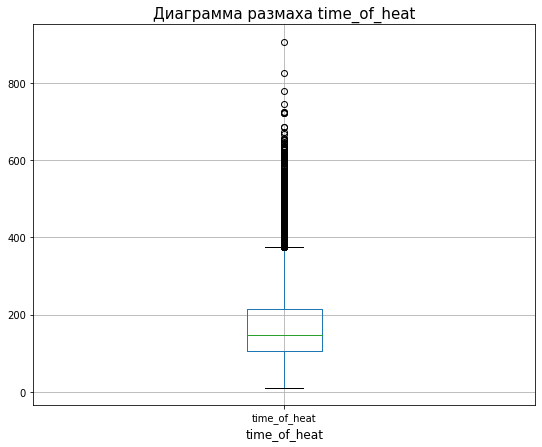

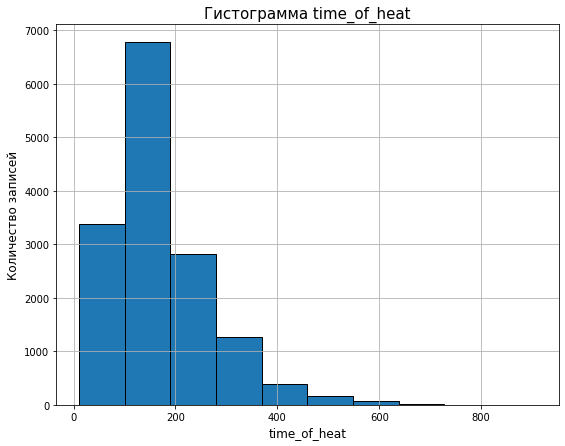

In [29]:
num_feature(data_arc['time_of_heat'])

In [30]:
upper_and_lower_limits(data_arc, 'time_of_heat')

'99% значений столбца time_of_heat лежат в диапазоне 26.00 и 578.50'

'Строки с time_of_heat больше максимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup,time_of_heat,full_sup
7799,1689,2019-07-05 11:30:50,2019-07-05 11:45:57,0.966775,0.675200,907.0,1.179215
12424,2701,2019-08-18 00:40:31,2019-08-18 00:54:17,1.027288,0.769083,826.0,1.283281
7433,1616,2019-07-03 00:41:18,2019-07-03 00:54:18,0.471394,0.369249,780.0,0.598796
2939,640,2019-05-28 03:01:03,2019-05-28 03:13:29,0.278164,0.190246,746.0,0.337000
4654,1005,2019-06-11 05:56:02,2019-06-11 06:08:07,0.944134,0.691533,725.0,1.170302


'Строки с time_of_heat меньше минимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup,time_of_heat,full_sup
4063,873,2019-06-06 12:25:13,2019-06-06 12:25:24,0.527412,0.384561,11.0,0.652726
7372,1601,2019-07-02 13:07:56,2019-07-02 13:08:07,0.510212,0.385029,11.0,0.639190
6590,1433,2019-06-26 06:46:07,2019-06-26 06:46:18,0.484169,0.324194,11.0,0.582685
9162,1987,2019-07-22 22:23:43,2019-07-22 22:23:54,0.659724,0.570459,11.0,0.872158
5596,1216,2019-06-18 11:00:44,2019-06-18 11:00:55,0.551280,0.404840,11.0,0.683963


Распределение времени нагрева стремится к нормальному со средним в 147 секунд. 99% значений столбца time_of_heat лежат в диапазоне 26.0 и 578.5. Осмотр выбивающихся значений не показал четких закономерностей. Нельзя однозначно утверждать, что такие данные не являются реальными.

###### Полная мощность

count    14876.000000
mean         0.823391
std          0.323460
min          0.275718
25%          0.578847
50%          0.746591
75%          1.030390
max          1.898158
Name: full_sup, dtype: float64

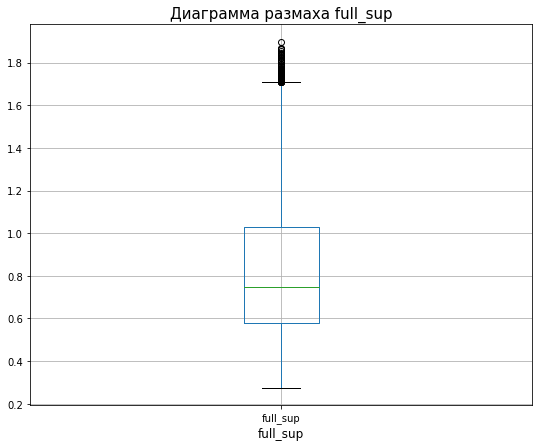

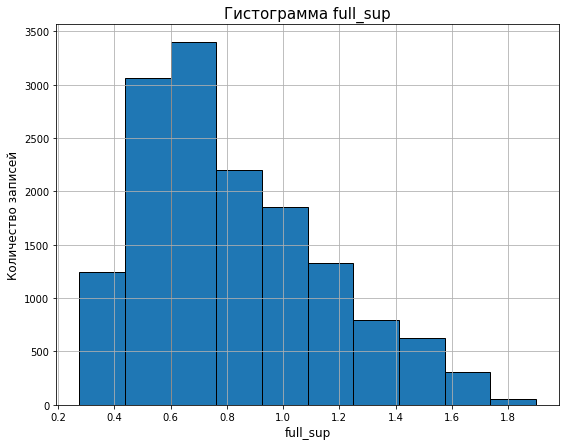

In [31]:
num_feature(data_arc['full_sup'])

In [32]:
upper_and_lower_limits(data_arc, 'full_sup')

'99% значений столбца full_sup лежат в диапазоне 0.32 и 1.72'

'Строки с full_sup больше максимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup,time_of_heat,full_sup
2591,564,2019-05-24 23:02:49,2019-05-24 23:05:31,1.410455,1.270284,162.0,1.898158
8091,1755,2019-07-07 18:04:39,2019-07-07 18:07:46,1.418481,1.212801,187.0,1.866273
3168,687,2019-05-30 06:58:10,2019-05-30 06:59:15,1.416122,1.214673,65.0,1.865699
3452,748,2019-06-01 16:24:02,2019-06-01 16:26:16,1.374768,1.258628,134.0,1.863902
8963,1944,2019-07-20 14:55:25,2019-07-20 14:59:27,1.399275,1.214912,242.0,1.853101


'Строки с full_sup меньше минимального'

,key,beg_of_heat,end_of_heat,act_sup,react_sup,time_of_heat,full_sup
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777,163.0,0.275718
14852,3237,2019-09-06 11:41:17,2019-09-06 11:45:12,0.223120,0.172958,235.0,0.282307
9014,1954,2019-07-21 06:26:02,2019-07-21 06:29:01,0.235934,0.157519,179.0,0.283685
13870,3010,2019-08-29 16:22:43,2019-08-29 16:24:57,0.223238,0.177071,134.0,0.284937
3382,733,2019-05-31 23:54:36,2019-05-31 23:58:30,0.228238,0.171438,234.0,0.285453


Распределение полной мощности стремится к нормальному со средним 0.82. 99% значений столбца full_sup лежат в диапазоне 0.32 и 1.72. Осмотр выбивающихся значений не показал четких закономерностей. Нельзя однозначно утверждать, что такие данные не являются реальными.

#### Данные о подаче сыпучих материалов

**Переименование столбцов**

In [33]:
data_bulk.rename(str.lower, axis = 'columns', inplace = True)
data_bulk.columns = data_bulk.columns.str.replace(' ', '_')

In [34]:
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

**Исследовательский анализ**

Проанализируем каждый элемент отдельно

Анализ элемента bulk_1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: bulk_1, dtype: float64

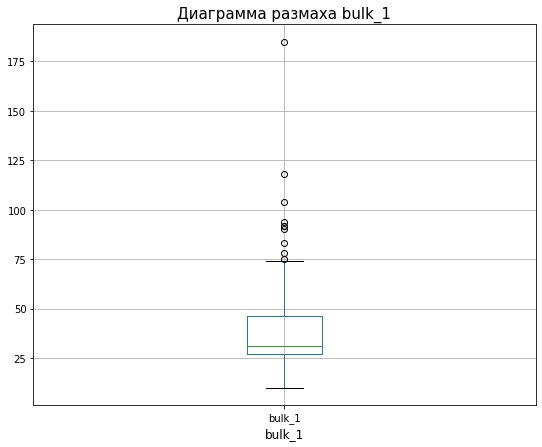

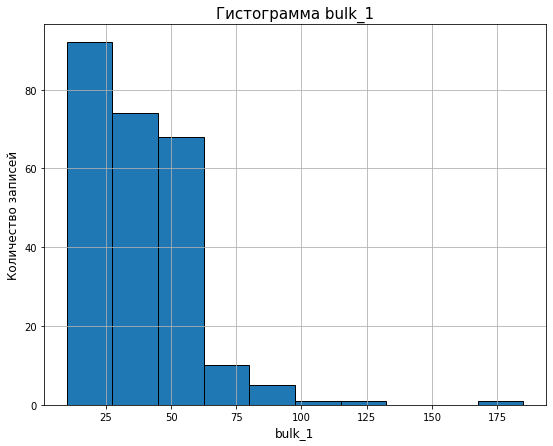



Анализ элемента bulk_2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: bulk_2, dtype: float64

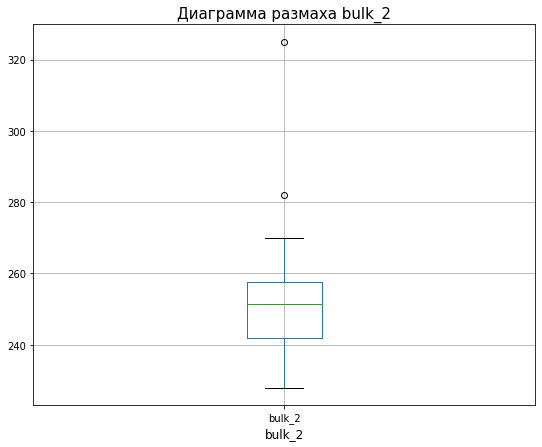

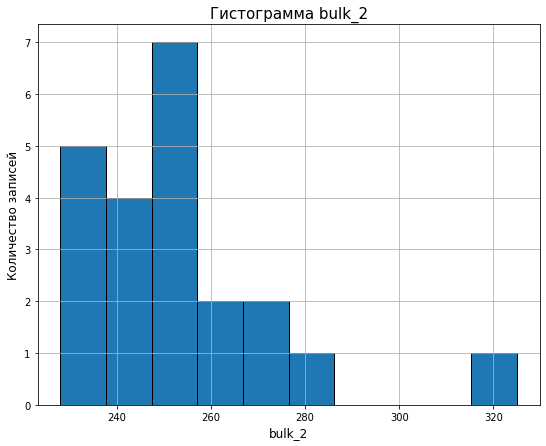



Анализ элемента bulk_3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: bulk_3, dtype: float64

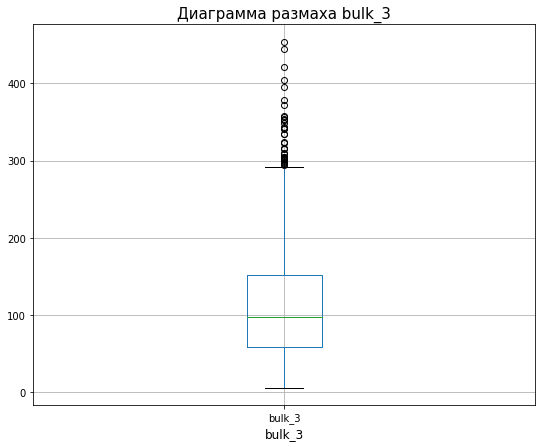

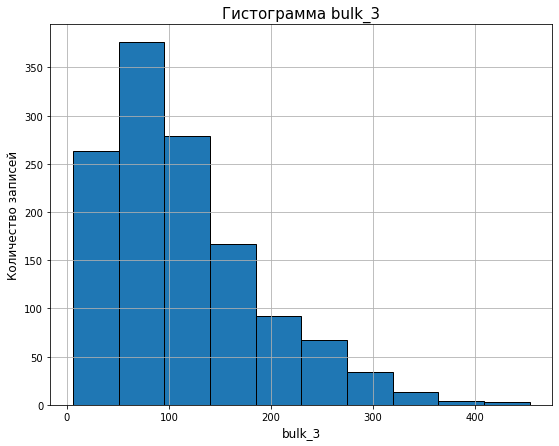



Анализ элемента bulk_4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: bulk_4, dtype: float64

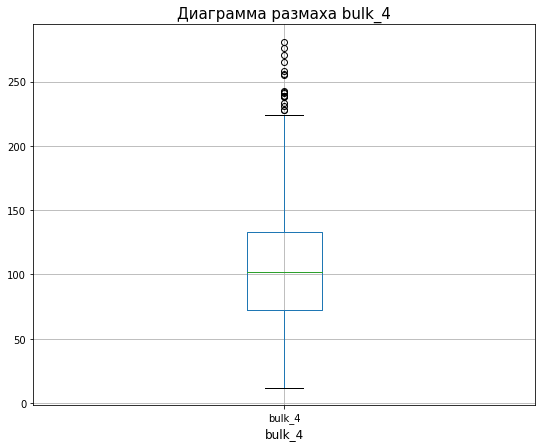

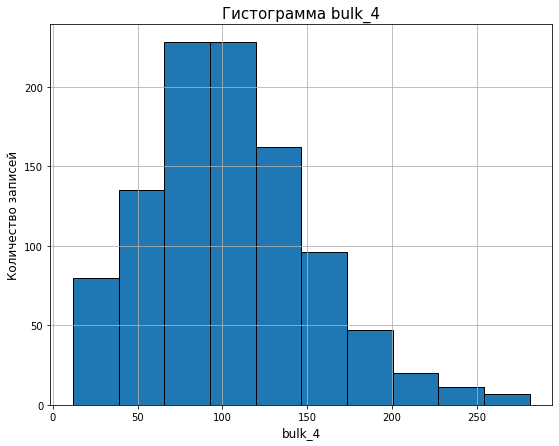



Анализ элемента bulk_5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: bulk_5, dtype: float64

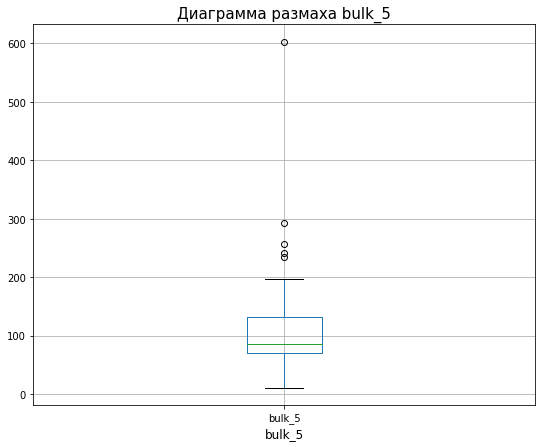

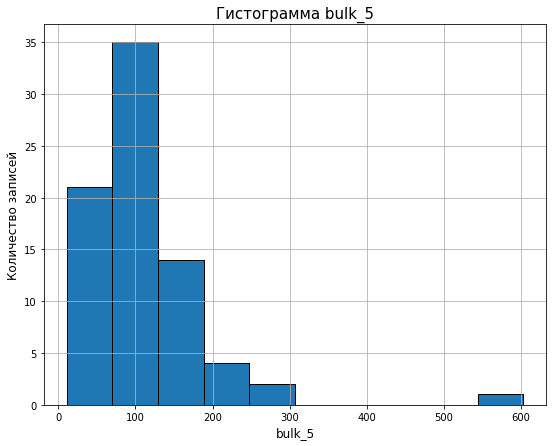



Анализ элемента bulk_6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: bulk_6, dtype: float64

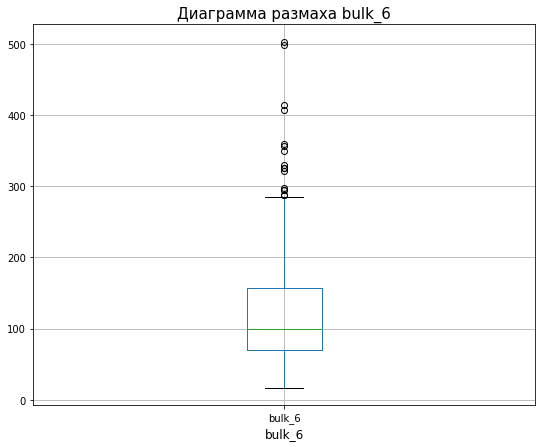

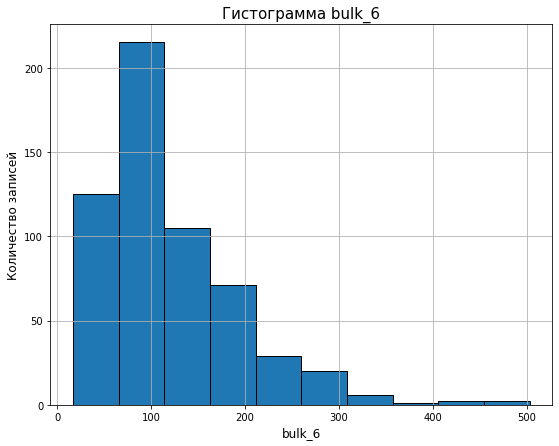



Анализ элемента bulk_7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: bulk_7, dtype: float64

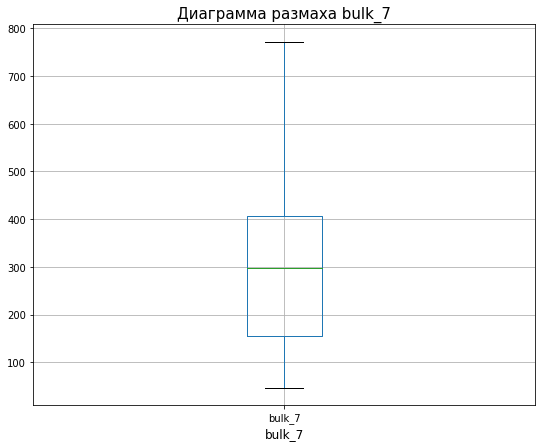

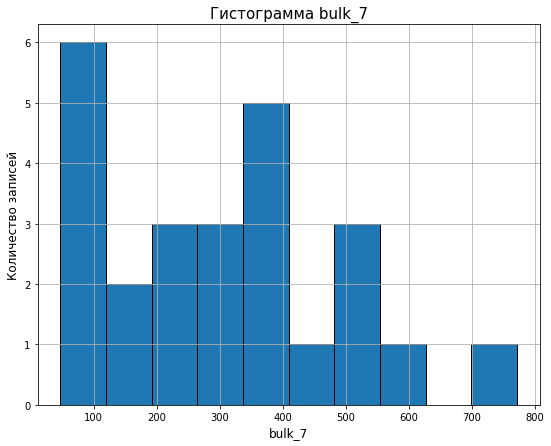



Анализ элемента bulk_8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: bulk_8, dtype: float64

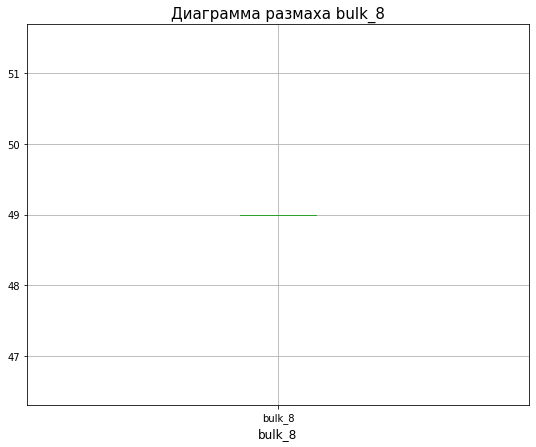

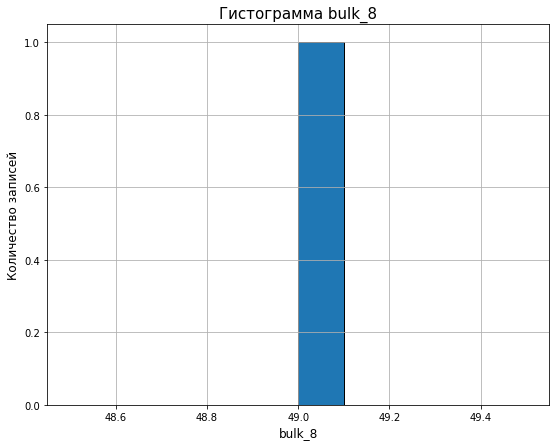



Анализ элемента bulk_9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: bulk_9, dtype: float64

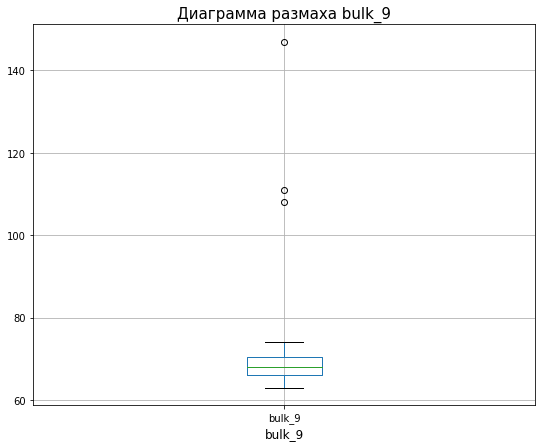

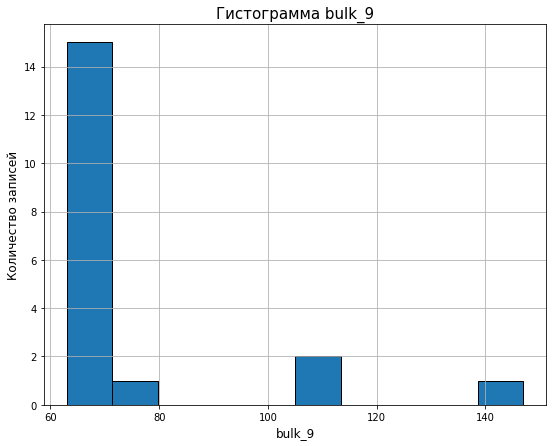



Анализ элемента bulk_10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: bulk_10, dtype: float64

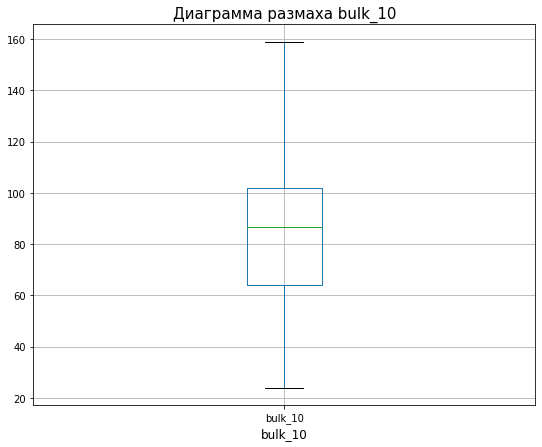

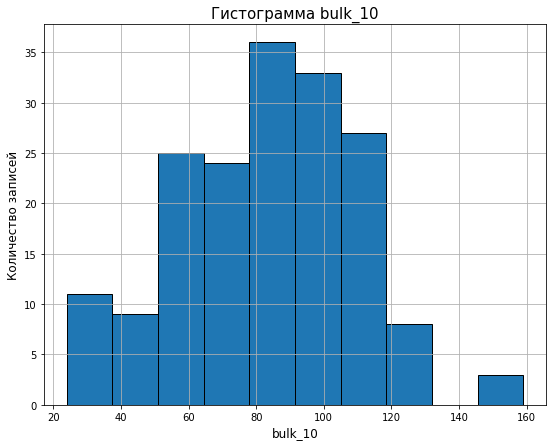



Анализ элемента bulk_11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: bulk_11, dtype: float64

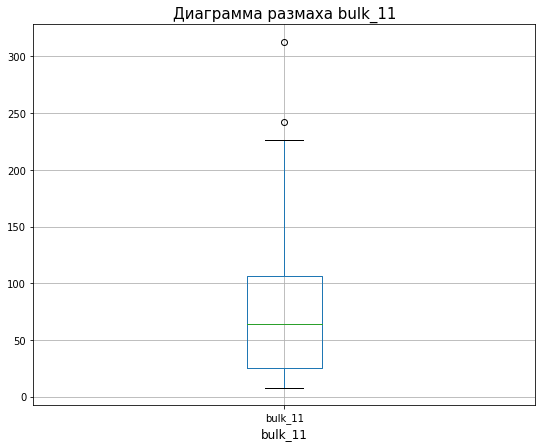

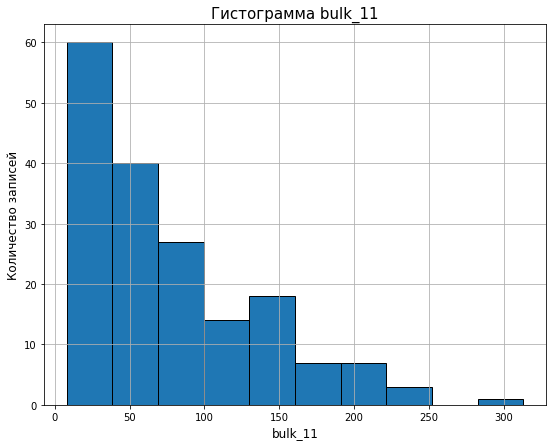



Анализ элемента bulk_12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: bulk_12, dtype: float64

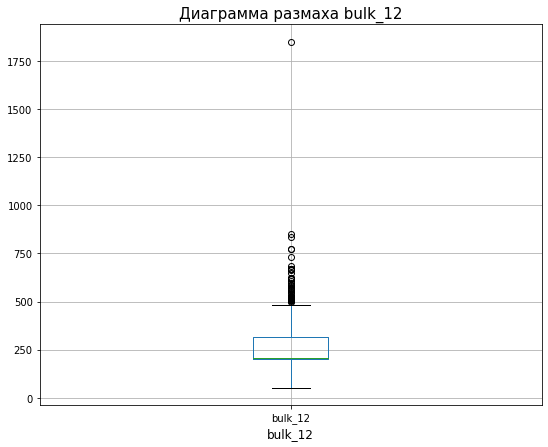

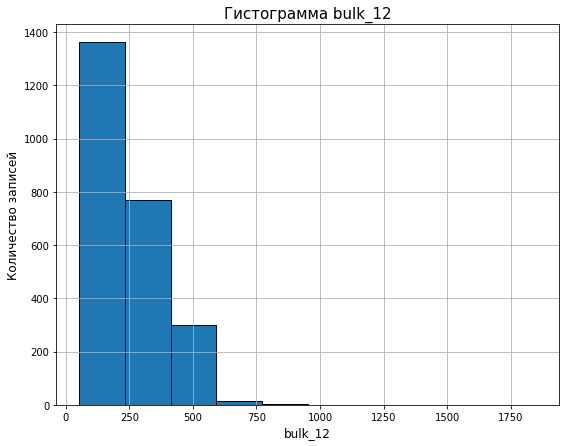



Анализ элемента bulk_13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: bulk_13, dtype: float64

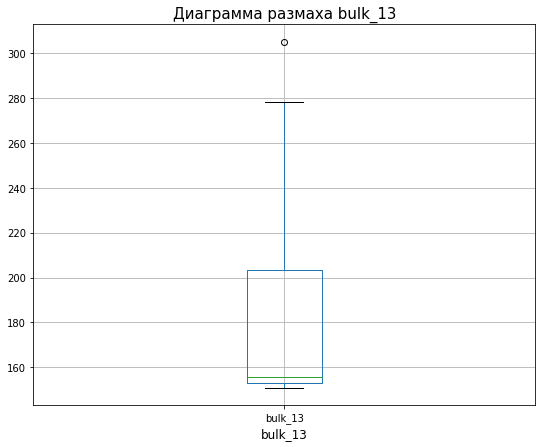

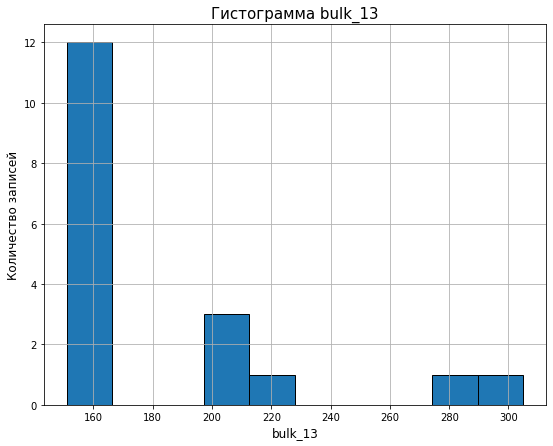



Анализ элемента bulk_14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: bulk_14, dtype: float64

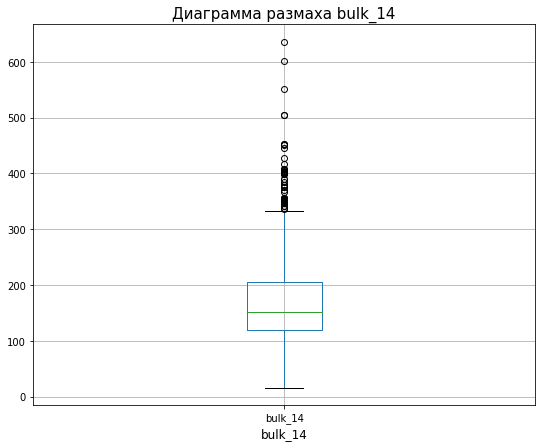

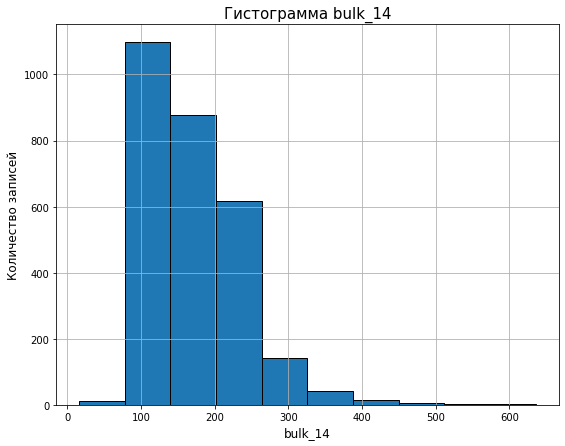



Анализ элемента bulk_15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: bulk_15, dtype: float64

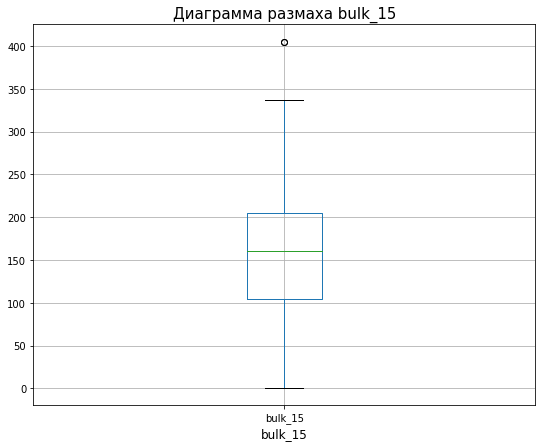

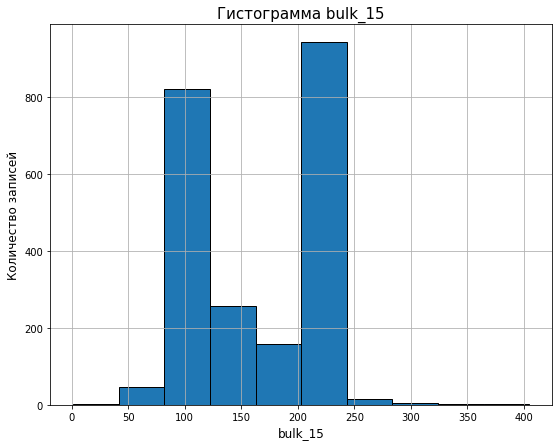

In [35]:
for column in data_bulk.columns:
    if column != 'key':
        print(f'Анализ элемента {column}')
        num_feature(data_bulk[column])
        print('\n')

Из анализа видно: 
* наиболее популярными добавками являются элементы: bulk_3, bulk_4, bulk_6, bulk_12, bulk_14, bulk_15 - содержатся в более чем 10% вариантов сплавов. Материал bulk_8 используется лишь в одном сплаве;
* для упрощения модели можно разбить содержание примесей на категории: малое, среднее, высокое.

Дополнительно проведем анализ попарного содержания наиболее часто встречающихся добавок в металле

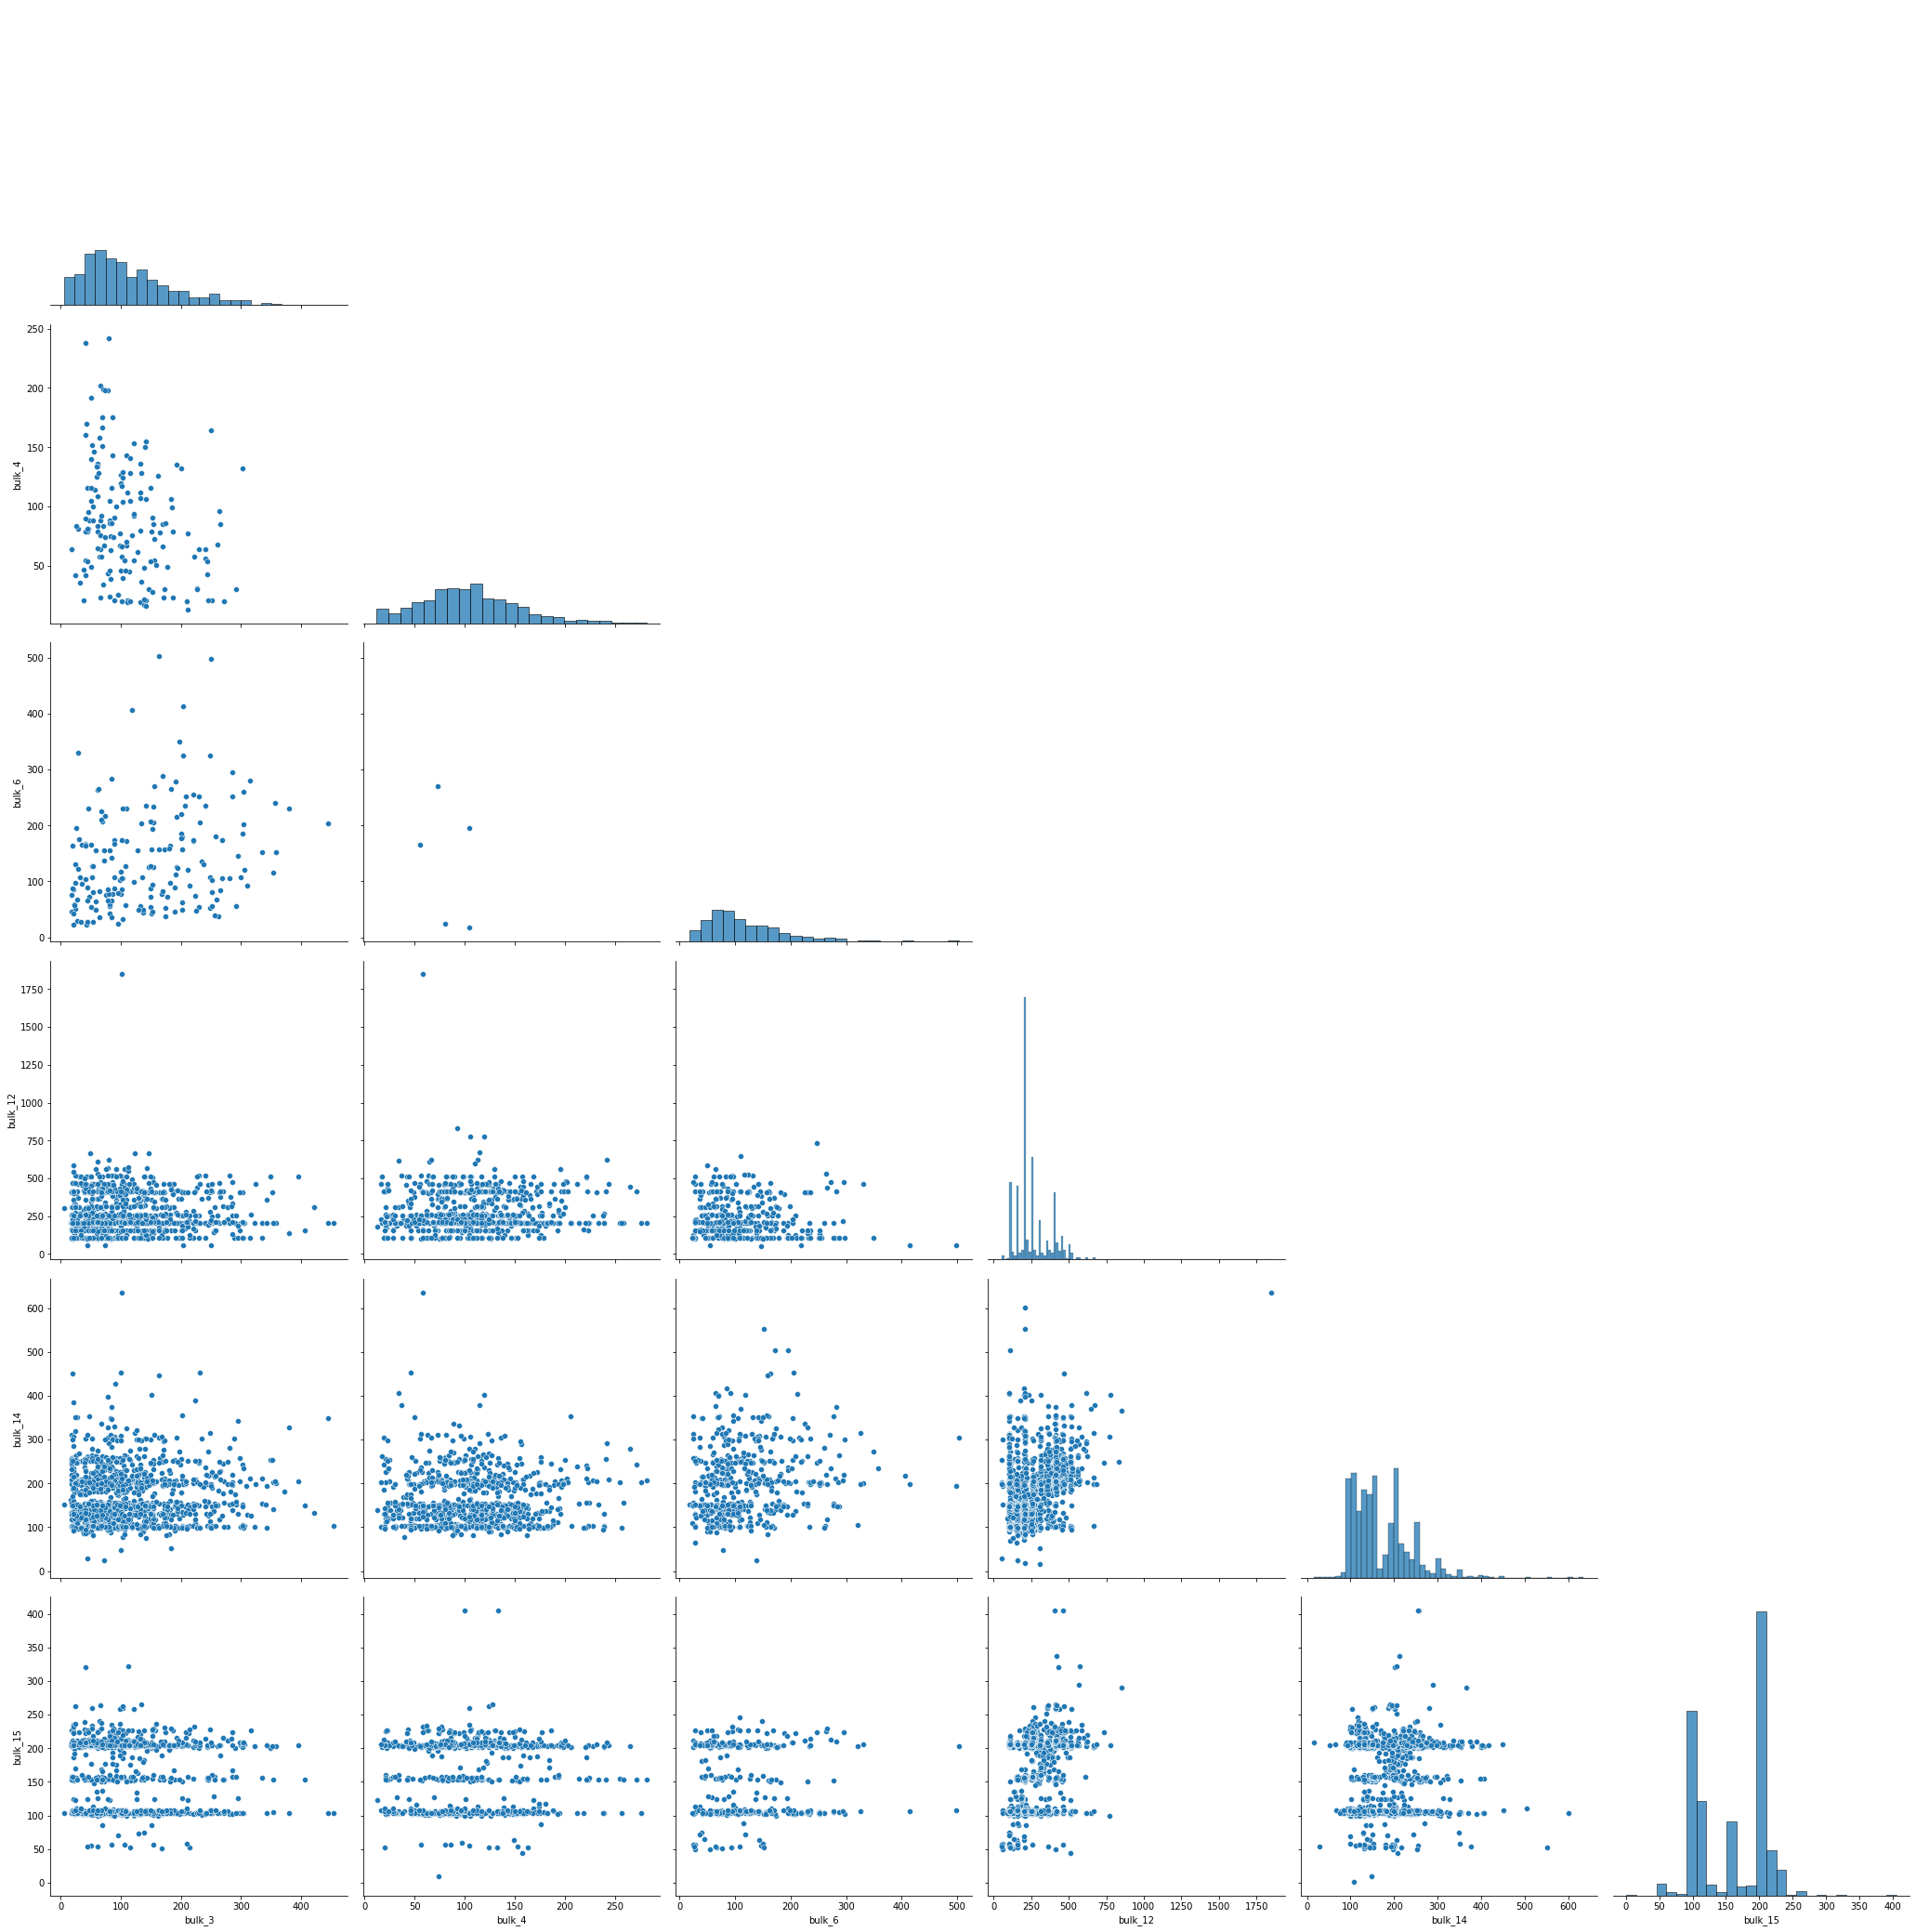

In [36]:
p = sns.pairplot(data_bulk[['bulk_3', 'bulk_4', 'bulk_6',
                           'bulk_12', 'bulk_14', 'bulk_15']], corner = True)
p.fig.set_size_inches(30,30)
plt.show()

Дополнительный анализ показал отсутствие прямой зависимости присадок bulk_3 и bulk_4, bulk_3 и bulk_6. Наиболее похожа на прямую зависимость между bulk_12 и bulk_14. Присадка bulk_15 имеет четкое разделение на 3 группы. Также можно заметить, что сплавы, одновременно содержащие bulk_4 и bulk_6, почти не встречаются на производстве.

#### Данные о времени подачи сыпучих материалов

**Переименование столбцов**

In [37]:
data_bulk_time.columns = data_bulk.columns

**Приведение к нужному формату**

In [38]:
columns_to_date(data_bulk_time, data_bulk_time.drop('key', axis = 1).columns)

**Исследовательский анализ**

Проанализируем верхние и нижние границы по дате добавления материалов:

Последние 5 добавлений материалов:

In [39]:
upper_and_lower_limits_of_time(data_bulk_time, 'bulk', 15)[0]

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
1,2019-09-05 06:10:59,2019-08-13 09:55:35,2019-09-06 11:54:15,2019-09-05 03:12:35,2019-09-02 17:34:47,2019-09-06 15:06:00,2019-09-05 18:40:50,NaT,2019-08-16 08:40:51,2019-09-04 09:44:31,2019-09-06 03:54:36,2019-09-06 12:18:35,2019-08-29 14:49:47,2019-09-06 16:07:29,2019-09-06 16:01:34
2,2019-09-05 02:37:08,2019-08-13 09:14:04,2019-09-06 11:04:20,2019-09-05 02:45:00,2019-09-02 16:58:07,2019-09-06 05:07:45,2019-09-05 16:39:32,NaT,2019-08-16 07:52:37,2019-09-03 05:57:25,2019-09-06 02:22:05,2019-09-06 11:49:45,2019-08-26 07:00:42,2019-09-06 14:58:15,2019-09-06 14:48:06
3,2019-09-05 01:56:45,2019-08-13 07:26:20,2019-09-06 08:43:49,2019-09-05 01:52:57,2019-09-02 16:19:39,2019-09-06 04:00:31,2019-08-13 11:01:00,NaT,2019-08-16 07:20:13,2019-09-03 05:40:49,2019-09-06 01:04:04,2019-09-06 11:04:20,2019-08-22 14:48:22,2019-09-06 12:31:49,2019-09-06 12:26:52
4,2019-09-04 20:51:19,2019-08-13 04:37:28,2019-09-06 08:34:53,2019-09-05 01:01:57,2019-09-02 15:08:19,2019-09-06 02:22:05,2019-08-13 09:39:09,NaT,2019-08-16 06:07:48,2019-09-02 04:45:41,2019-08-31 01:24:06,2019-09-06 10:50:02,2019-08-07 06:23:16,2019-09-06 11:45:22,2019-09-06 11:40:06


Первые 5 добавлений материалов:

In [40]:
upper_and_lower_limits_of_time(data_bulk_time, 'bulk', 15)[1]

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2019-05-05 16:26:52,2019-05-07 16:16:34,2019-05-04 04:25:29,2019-05-03 11:36:50,2019-05-07 16:46:56,2019-05-03 21:36:10,2019-05-15 22:42:51,NaT,2019-05-14 12:35:40,2019-05-07 01:15:07,2019-05-06 16:18:00,2019-05-03 11:53:30,2019-05-11 03:35:36,2019-05-03 11:48:37,2019-05-03 11:44:39
2,2019-05-05 17:18:36,2019-05-07 19:13:07,2019-05-04 05:15:12,2019-05-03 12:32:39,2019-05-07 19:04:09,2019-05-03 23:40:36,2019-06-17 02:23:02,NaT,2019-05-14 13:02:53,2019-05-07 01:56:53,2019-05-07 00:01:30,2019-05-03 12:27:13,2019-05-11 08:18:48,2019-05-03 12:21:01,2019-05-03 12:16:16
3,2019-05-05 18:32:50,2019-05-07 22:50:29,2019-05-04 07:13:45,2019-05-03 12:43:22,2019-05-07 22:32:04,2019-05-04 01:14:08,2019-06-23 21:47:17,NaT,2019-05-14 13:47:34,2019-05-07 03:10:27,2019-05-07 09:53:19,2019-05-03 12:58:00,2019-05-16 05:29:33,2019-05-03 12:51:11,2019-05-03 12:46:36
4,2019-05-05 19:34:07,2019-05-08 01:46:58,2019-05-04 08:13:13,2019-05-03 13:30:47,2019-05-08 01:25:11,2019-05-04 07:30:19,2019-07-20 16:22:44,NaT,2019-05-14 14:10:18,2019-05-07 03:32:28,2019-05-07 18:04:04,2019-05-03 13:30:47,2019-05-28 08:15:29,2019-05-03 13:34:12,2019-05-03 13:30:47


In [41]:
(data_bulk.drop('key', axis = 1).isna() ^ data_bulk_time.drop('key', axis = 1).isna()).sum()

bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

Анализ показал: все записи сделаны в 2019 году с мая по сентябрь, bulk_8 добавлен лишь один раз - в июле. Совместный анализ пропусков data_bulk и data_bulk_time показывает, что время добавки сыпучих материалов фиксируется корректно: пропуски соответствуют друг другу.

#### Данные о продувке сплава газом

**Переименование столбцов**

In [42]:
data_gas.columns = ['key', 'gas']

**Исследовательский анализ**

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

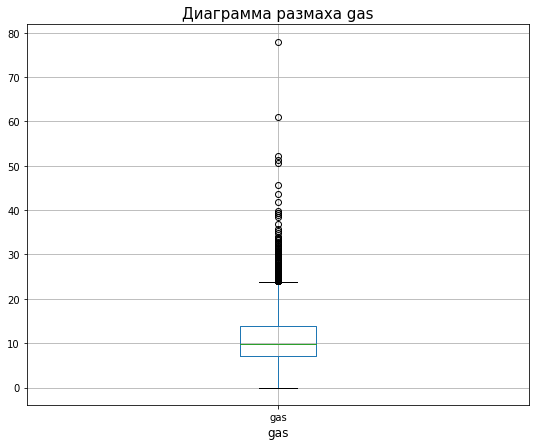

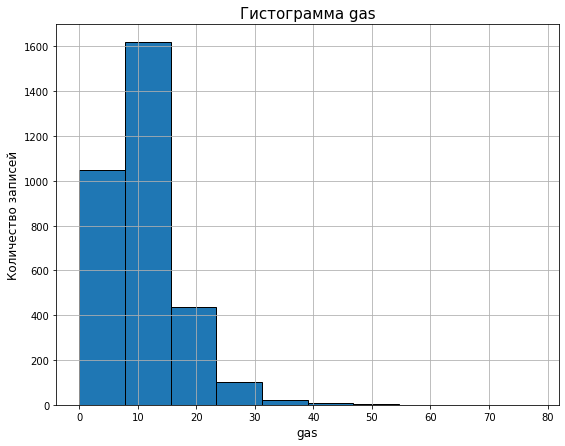

In [43]:
num_feature(data_gas['gas'])

In [44]:
upper_and_lower_limits(data_gas, 'gas')

'99% значений столбца gas лежат в диапазоне 0.79 и 34.68'

'Строки с gas больше максимального'

,key,gas
319,322,77.995040
277,280,60.935689
2107,2110,52.142373
2567,2570,51.380229
116,117,50.581035


'Строки с gas меньше минимального'

,key,gas
863,866,0.008399
1044,1047,0.016696
2100,2103,0.263029
2353,2356,0.275081
352,355,0.325733


Распределение продувки газом стремится к нормальному со средним в 11. 99% значений столбца gas лежат в диапазоне 0.79 и 34.68. Осмотр выбивающихся значений не показал четких закономерностей. Нельзя однозначно утверждать, что такие данные не являются реальными.

#### Результаты измерения температуры

**Переименование столбцов**

In [45]:
data_temp.columns = ['key', 'time', 'temp']

**Приведение к нужному формату**

In [46]:
columns_to_date(data_temp, ['time'])

**Анализ пропусков**

In [47]:
data_temp[data_temp['temp'].isna()]

,key,time,temp
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Можно заметить, что последние 3427 строк измерения температуры не записались и не вошли в итоговый датасет. Такие данные не могут быть восстановлены, их объем более 15%, что является существенной потерей. На это необходимо указать команде, занимающейся выгрузкой и записью данных.

Из-за невозможности восстановления данных, исключим строки с пропусками из анализа.

In [48]:
data_temp.dropna(inplace = True)

**Исследовательский анализ**

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64

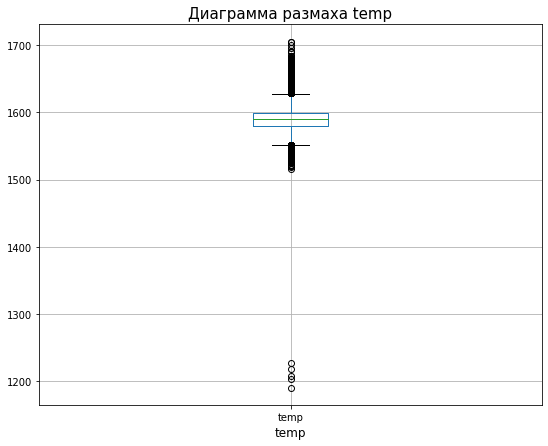

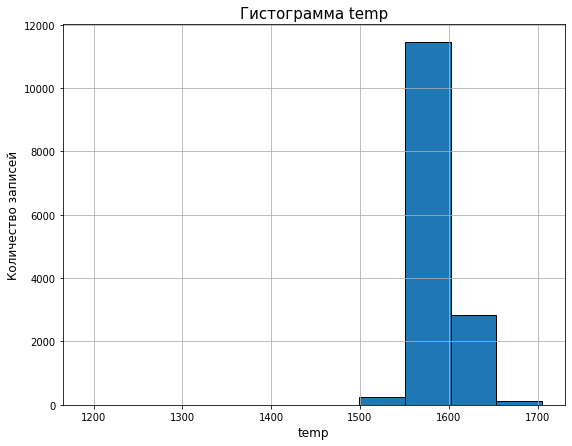

In [49]:
num_feature(data_temp['temp'])

In [50]:
upper_and_lower_limits(data_temp, 'temp')

'99% значений столбца temp лежат в диапазоне 1538.00 и 1661.00'

'Строки с temp больше максимального'

,key,time,temp
1862,330,2019-05-16 05:59:20,1705.0
1861,330,2019-05-16 05:52:20,1704.0
1863,330,2019-05-16 06:07:54,1700.0
10158,1817,2019-07-09 23:39:57,1696.0
10157,1817,2019-07-09 23:35:45,1691.0


'Строки с temp меньше минимального'

,key,time,temp
4883,867,2019-06-06 08:03:39,1191.0
14283,2561,2019-08-12 18:49:29,1204.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0


В технической документации для легированной стали установлена минимальная температура плавки в 1320 градусов. Заказчиком не установлен нижний предел по температурам, однако такие замеры не пригодятся для дальнейшего анализа, так как вероятнее всего являются следствием нарушения технологичнского процесса.

In [51]:
data_temp = data_temp[data_temp['temp'] > 1320]

Распределение температуры сплава стремится к нормальному со средним в 1590 градусов. 99% значений столбца temp лежат в диапазоне 1538 и 1661. Осмотр выбивающихся значений не показал четких закономерностей. Однако необходимо исключить из исследования наблюдения с температурой менее 1320 градусов.

**Переименование столбцов**

In [52]:
data_wire.rename(str.lower, axis = 'columns', inplace = True)
data_wire.columns = data_wire.columns.str.replace(' ', '_')

In [53]:
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

**Исследовательский анализ**

Проанализируем каждый элемент отдельно

Анализ элемента wire_1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: wire_1, dtype: float64

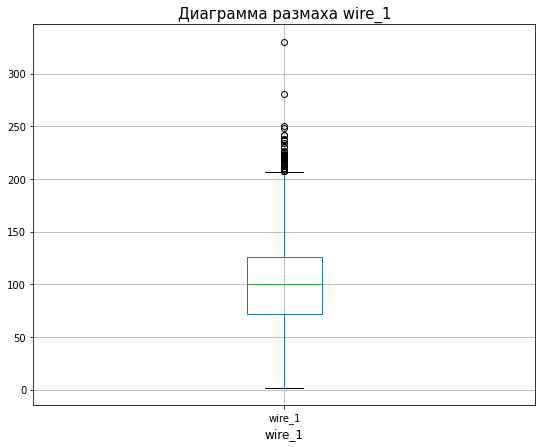

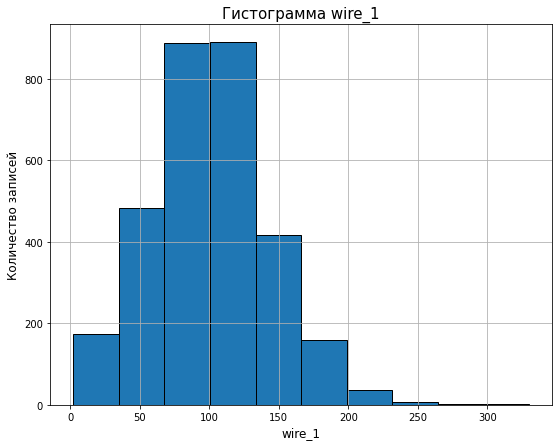



Анализ элемента wire_2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: wire_2, dtype: float64

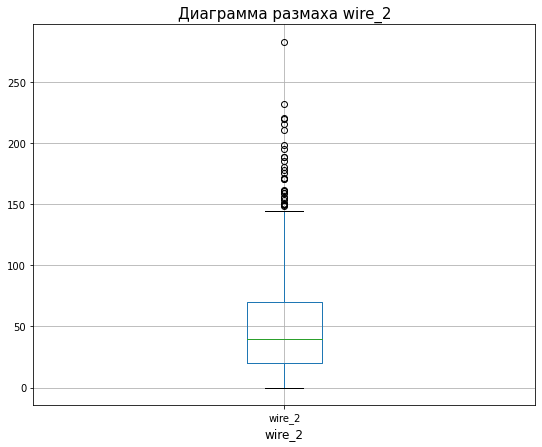

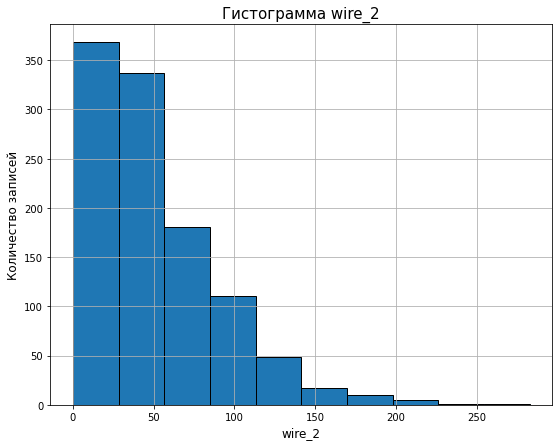



Анализ элемента wire_3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: wire_3, dtype: float64

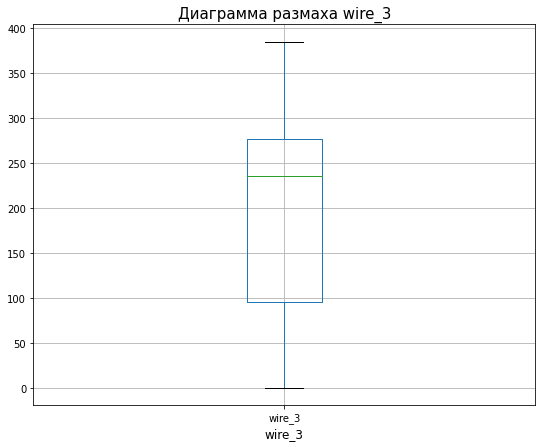

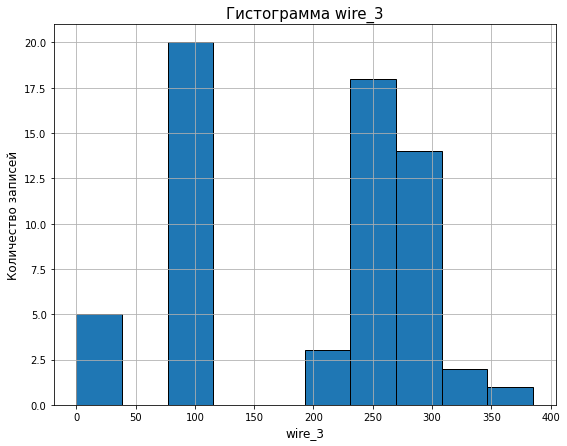



Анализ элемента wire_4


count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: wire_4, dtype: float64

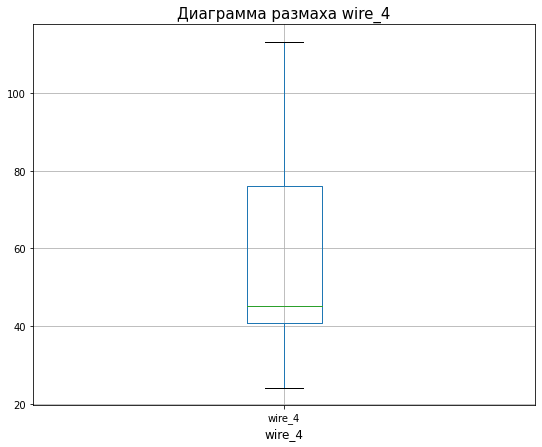

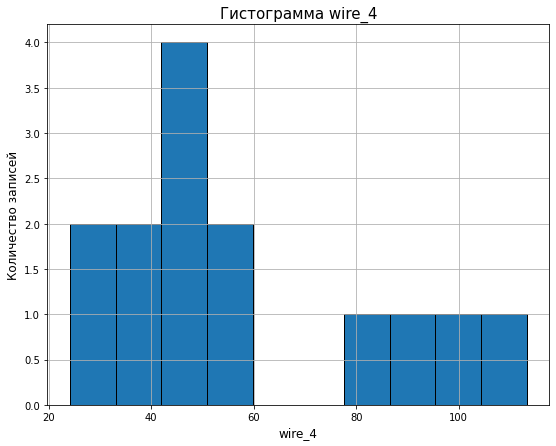



Анализ элемента wire_5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: wire_5, dtype: float64

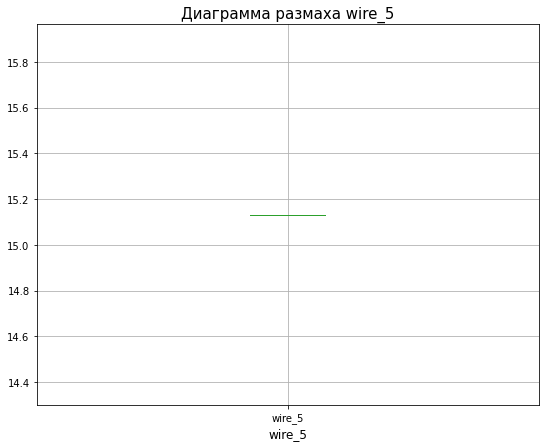

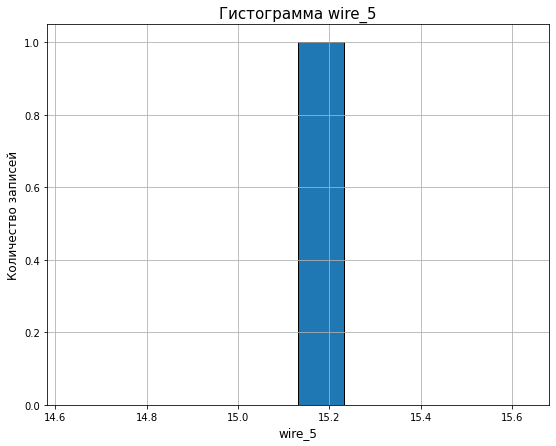



Анализ элемента wire_6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: wire_6, dtype: float64

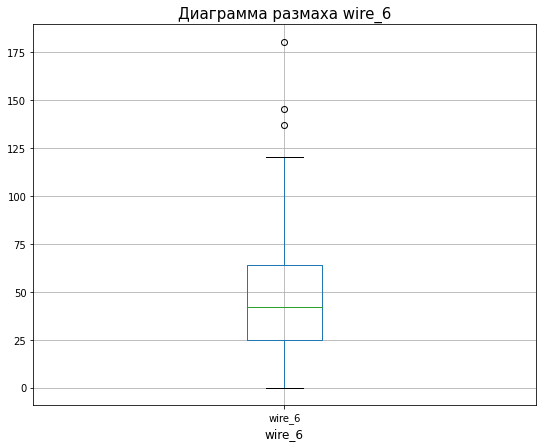

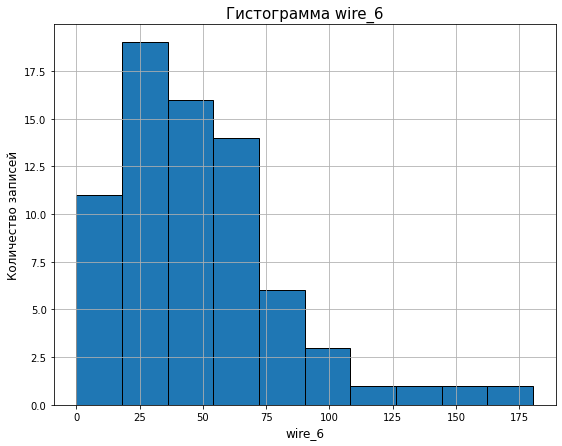



Анализ элемента wire_7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: wire_7, dtype: float64

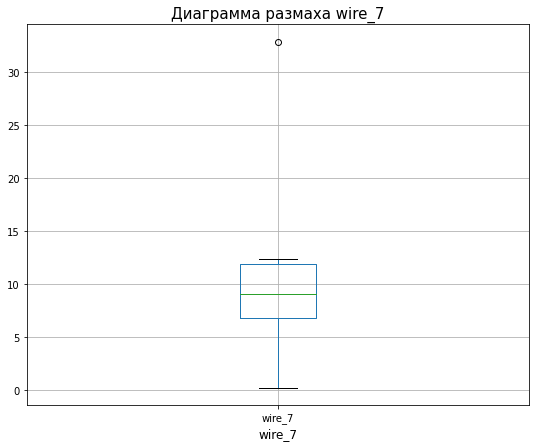

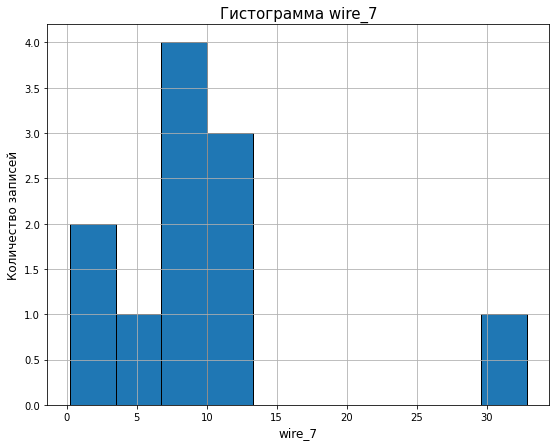



Анализ элемента wire_8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: wire_8, dtype: float64

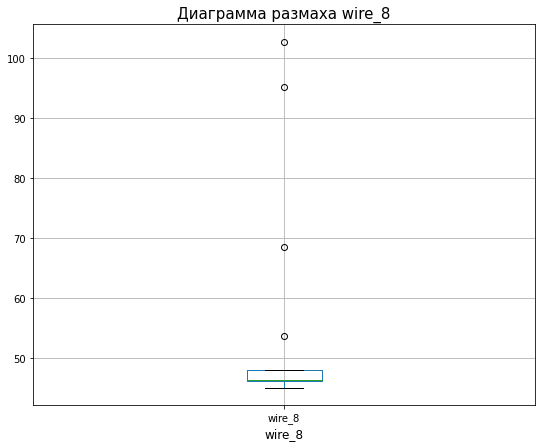

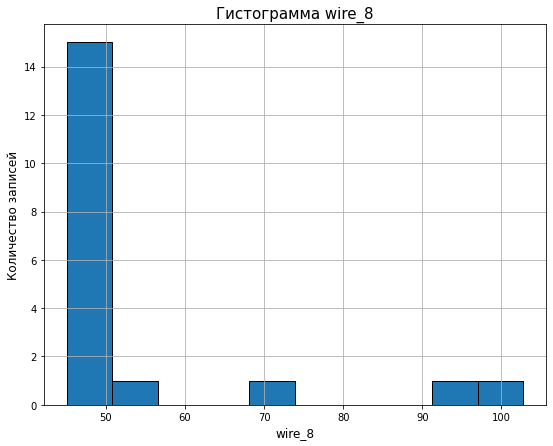



Анализ элемента wire_9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: wire_9, dtype: float64

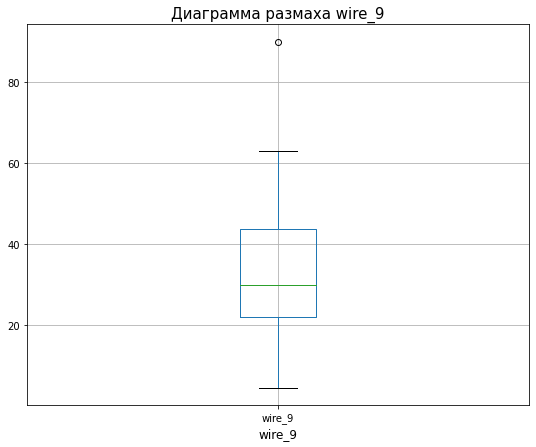

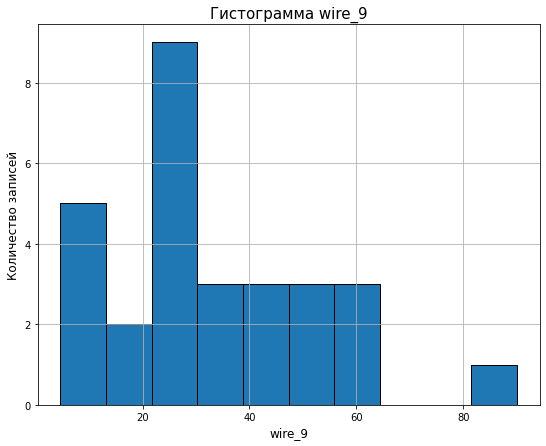

In [54]:
for column in data_wire.columns:
    if column != 'key':
        print(f'Анализ элемента {column}')
        num_feature(data_wire[column])
        print('\n')

Из анализа видно: 
* наиболее популярными добавками являются элементы: wire_1, wire_2 - содержатся в более чем 10% вариантов сплавов. Материал wire_1 используется в 99% сплавов, wire_5 используется лишь в одном;
* для упрощения модели можно разбить содержание примесей на категории: малое, среднее, высокое.

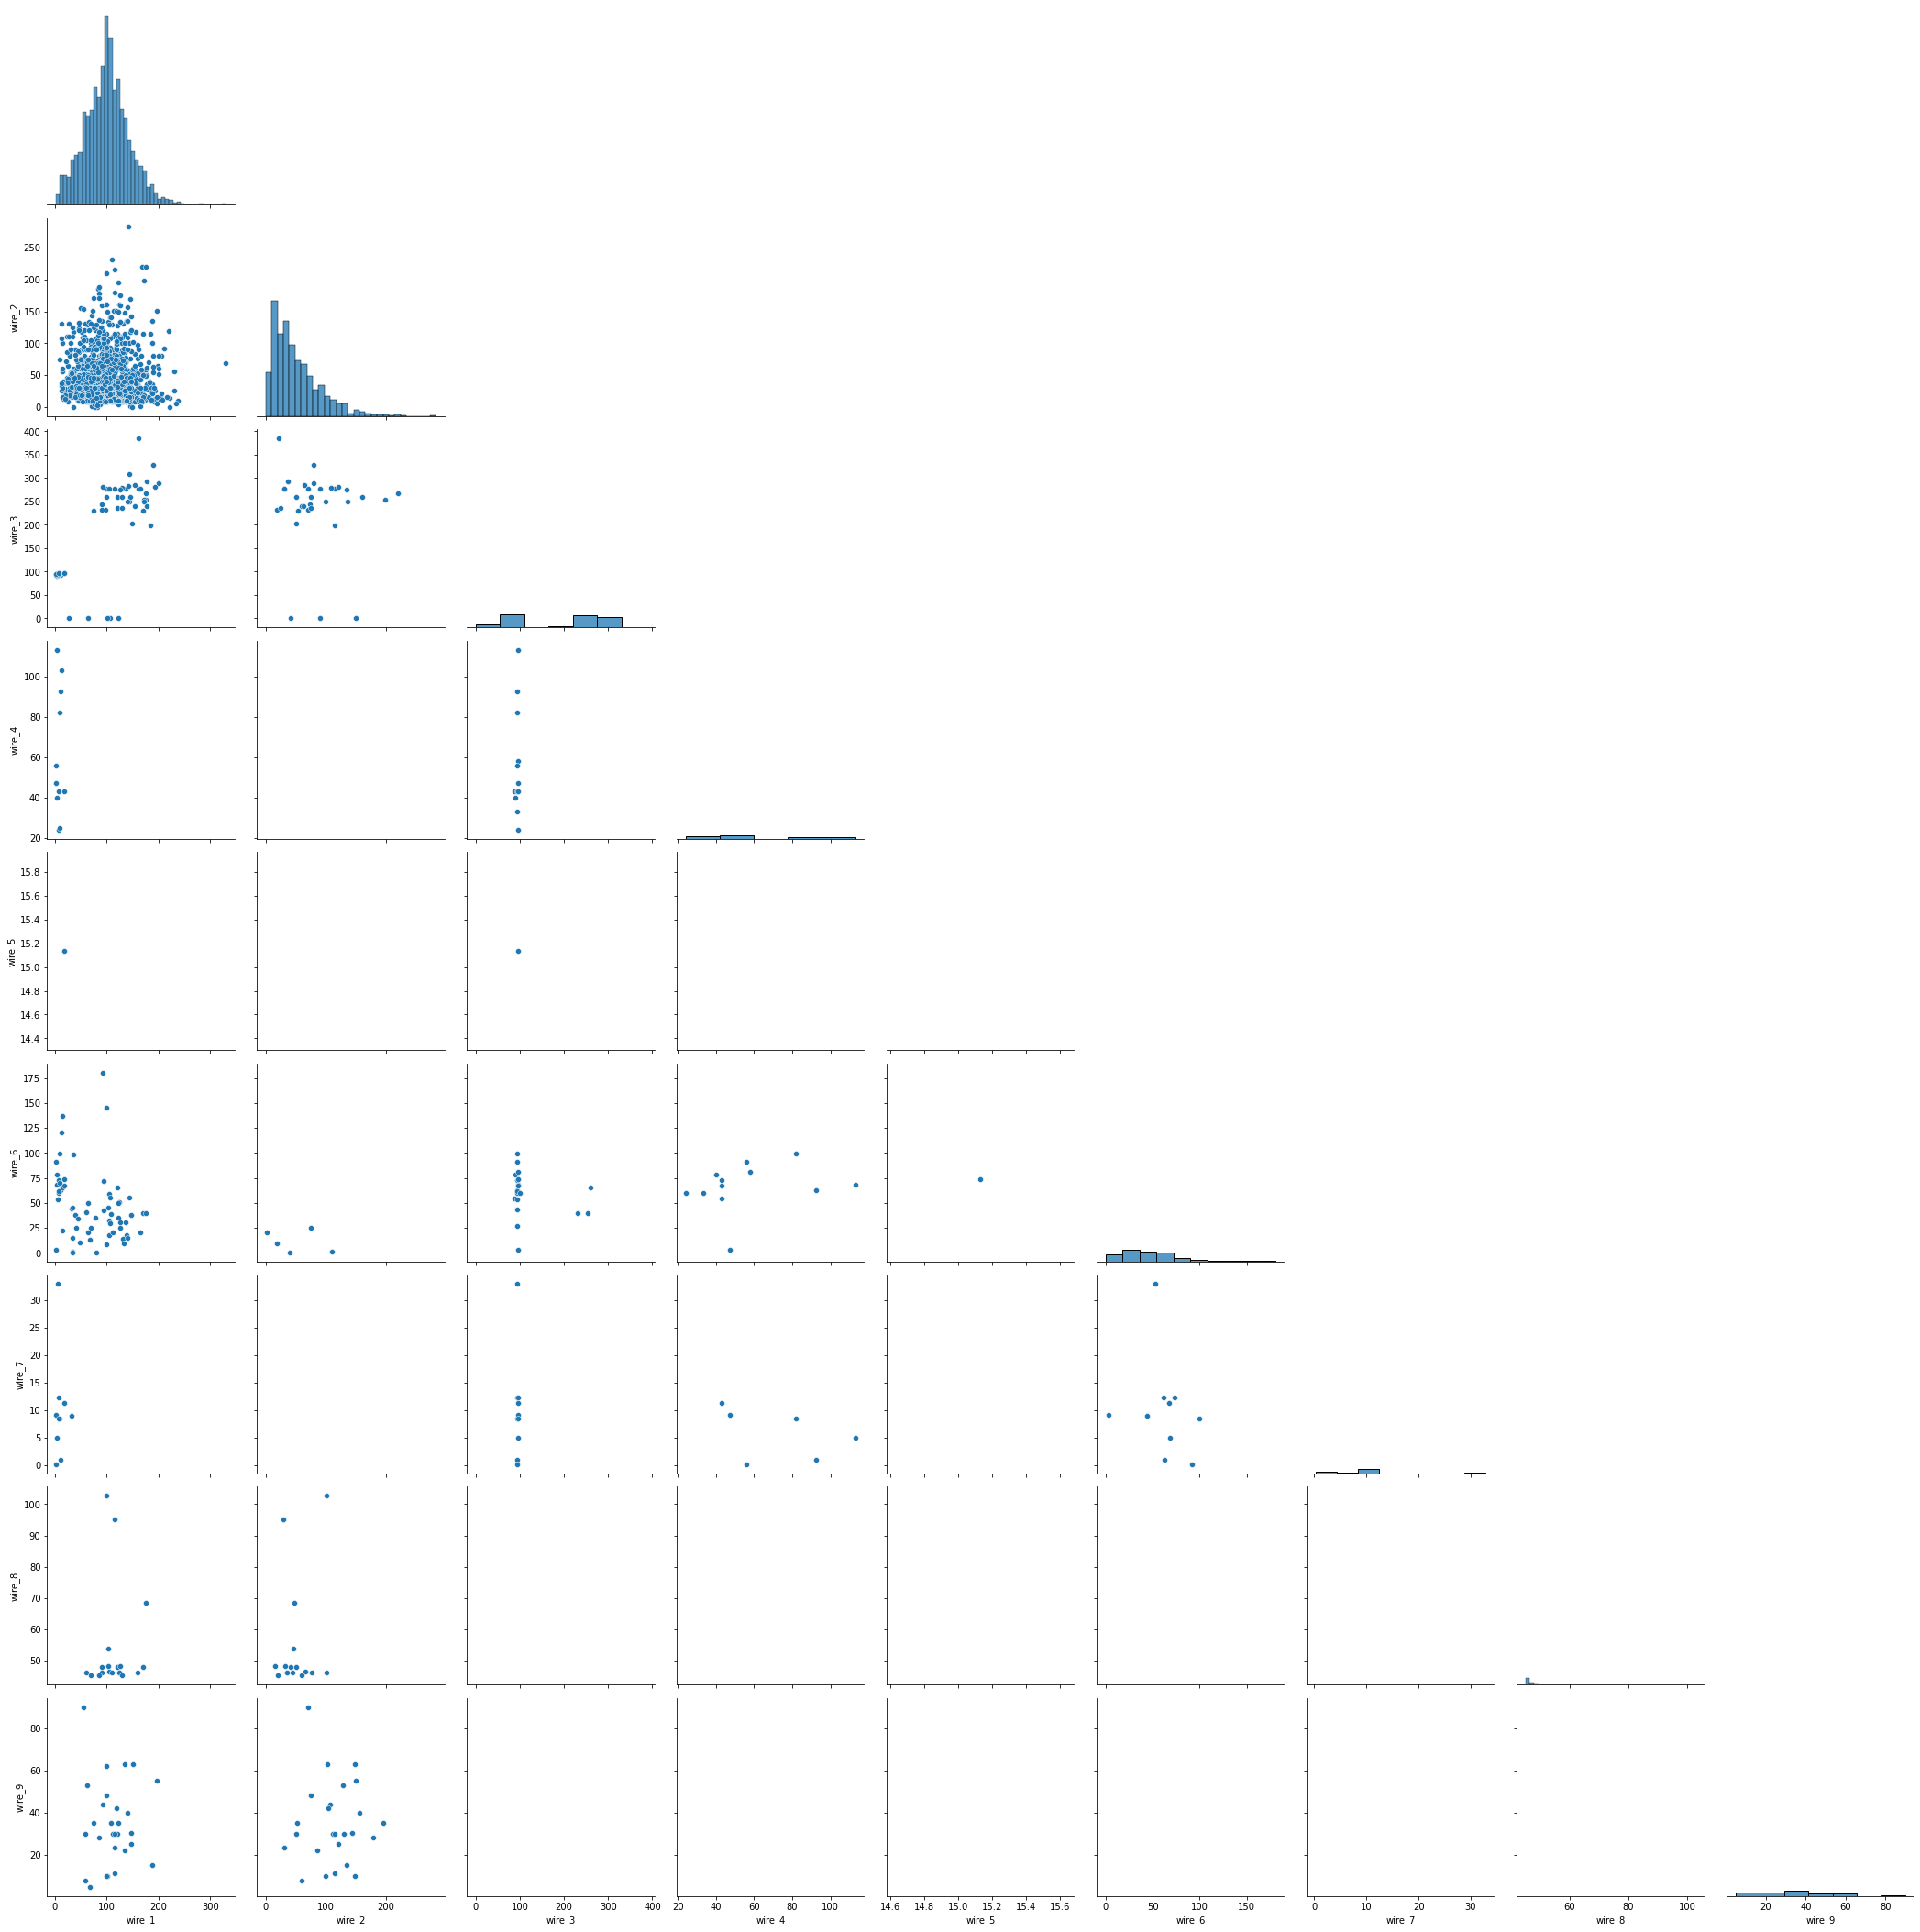

In [55]:
g = sns.pairplot(data_wire.drop('key', axis = 1), corner = True)
g.fig.set_size_inches(30,30)
plt.show()

Дополнительный анализ помог выявить следующие особенности:
* присадки wire_8, wire_9 используются только с wire_1 и wire_2;
* c присадкой wire_7 не используются wire_2, wire 5;
* c присадкой wire_5 не используются wire_2, wire 4;
* c присадкой wire_4 не используется wire_2.

#### Данные о времени подачи проволочных материалов

**Переименование столбцов**

In [56]:
data_wire_time.columns = data_wire.columns

**Приведение к нужному формату**

In [57]:
columns_to_date(data_wire_time, data_wire_time.drop('key', axis = 1).columns)

**Исследовательский анализ**

Проанализируем верхние и нижние границы по дате добавления материалов:

Последние 5 добавлений материалов:

In [58]:
upper_and_lower_limits_of_time(data_wire_time, 'wire', 9)[0]

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
1,2019-09-06 15:33:55,2019-09-06 01:38:22,2019-09-01 13:28:06,2019-08-12 19:51:09,NaT,2019-08-18 18:25:03,2019-08-13 07:49:49,2019-08-16 08:14:32,2019-08-09 14:03:42
2,2019-09-06 14:36:11,2019-09-05 20:40:37,2019-09-01 12:41:21,2019-07-27 19:41:36,NaT,2019-08-18 17:05:42,2019-08-13 02:52:06,2019-08-16 07:39:37,2019-08-09 13:07:31
3,2019-09-06 12:18:35,2019-09-05 16:45:51,2019-08-26 03:34:51,2019-07-27 17:07:27,NaT,2019-08-18 16:20:32,2019-08-13 01:13:45,2019-08-16 06:42:52,2019-08-09 11:16:48
4,2019-09-06 11:33:38,2019-09-05 12:46:02,2019-08-26 02:15:46,2019-07-27 13:57:58,NaT,2019-08-18 15:43:21,2019-08-12 23:20:37,2019-08-16 05:36:19,2019-08-09 10:17:13


Первые 5 добавлений материалов:

In [59]:
upper_and_lower_limits_of_time(data_wire_time, 'wire', 9)[1]

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
1,2019-05-03 11:36:50,2019-05-03 13:48:52,2019-05-04 05:41:29,2019-05-07 16:46:56,NaT,2019-05-07 16:16:34,2019-07-27 07:56:34,2019-05-14 12:18:01,2019-06-02 15:42:11
2,2019-05-03 12:11:46,2019-05-03 15:39:37,2019-05-07 15:39:35,2019-05-07 23:21:42,NaT,2019-05-07 17:37:05,2019-07-27 13:43:32,2019-05-14 12:52:37,2019-06-02 18:02:35
3,2019-05-03 12:43:22,2019-05-03 16:22:36,2019-05-07 17:12:49,2019-07-20 16:11:26,NaT,2019-05-07 21:53:14,2019-07-27 19:11:22,2019-05-14 13:20:41,2019-06-02 18:51:06
4,2019-05-03 13:20:44,2019-05-03 18:40:57,2019-05-07 22:24:56,2019-07-20 23:21:17,NaT,2019-05-07 23:01:42,2019-08-12 19:47:06,2019-05-14 14:05:13,2019-06-02 20:35:26


In [60]:
(data_wire.drop('key', axis = 1).isna() ^ data_wire_time.drop('key', axis = 1).isna()).sum()

wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Анализ показал: все записи сделаны в 2019 году с мая по сентябрь, wire_5 добавлен лишь один раз - в августе. Совместный анализ пропусков data_wire и data_wire_time показывает, что время добавки проволочных материалов фиксируется корректно: пропуски соответствуют друг другу.

**Вывод:** наименования столбцов датасетов приведены к змеиному языку, установлен формат datetime для столбцов с датой, добавлен новый признак: время нагрева, выполнен исследовательский анализ числовых данных.

### Объединение датасетов

**Формирование общего датасета начнем с таргета - последнего замера температуры партии:**

Отберем партии с количеством замеров температуры больше 1

In [61]:
keys = data_temp.groupby('key')['temp'].count()>1
keys

key
1        True
2        True
3        True
4        True
5        True
        ...  
3237    False
3238    False
3239    False
3240    False
3241    False
Name: temp, Length: 3215, dtype: bool

Составим сводную таблицу по номеру партии с первым и последним замером температуры

In [62]:
data = (data_temp.pivot_table(
                            index = 'key',
                            values = ['temp'],
                            aggfunc = ['last', 'first'])[keys])

data.columns = ['last_mes','first_mes']

data

,last_mes,first_mes
key,,
1,1613.0,1571.0
2,1602.0,1581.0
3,1599.0,1596.0
4,1625.0,1601.0
5,1602.0,1576.0
...,...,...
2495,1591.0,1570.0
2496,1591.0,1554.0
2497,1589.0,1571.0


Добавим новый признак "предпоследний замер температуры"

In [63]:
for key in data.index:
    key_series = data_temp[data_temp['key'] == key].reset_index(drop=True)
    data.loc[key,'prev_mes'] = key_series.loc[len(key_series)-2,'temp']

In [64]:
data.head()

,last_mes,first_mes,prev_mes
key,,,
1,1613.0,1571.0,1606.0
2,1602.0,1581.0,1604.0
3,1599.0,1596.0,1600.0
4,1625.0,1601.0,1617.0
5,1602.0,1576.0,1586.0


**Добавим данные об электродах**

Добавим к общему датасету температур сводную таблицу по ключам с суммарной активной, реактивной и полной мощностями, а также временем нагрева.
Время начала и окончания нагрева считаем нерелевантными признаками, так как они не могут повлиять на физические свойства сплава.

In [65]:
data = data.join(data_arc.pivot_table(
                                    index = 'key',
                                    values = ['act_sup', 'full_sup', 'react_sup', 'time_of_heat'],
                                    aggfunc = 'sum'),
                how = 'inner')

**Добавим данные о подаче сыпучих материалов**

Откажемся от упрощения модели путем замены содержания популярных примесей категориальными значениями "малое", "среднее", "высокое". Однако заменим категориальным признаком содержание непопулярных добавок: 'bulk_1', 'bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11','bulk_13'- а именно: есть/нет.

In [66]:
unpop_bulk = ['bulk_1', 'bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13']

In [67]:
for material in unpop_bulk:
    data_bulk[material] = data_bulk[material].notna().astype('int')

Заполним отсутствие данных по примесям 0. Это правильное решение, поскольку отсутствие информации о количестве легирующего материала говорит о его отсутствии в сплаве.

In [68]:
data_bulk.fillna(0, inplace = True)

Добавим к датасету информацию о подаче сыпучих материалов кроме материала bulk_8, так как известен лишь один сплав с его применением, а значит, этот признак будет привносить шум в предсказание модели: необходимо собрать больше данных о сплаве с этой добавкой

In [69]:
data = data.join(data_bulk.set_index('key').drop('bulk_8', axis = 1),
                how = 'inner')

Время подачи сыпучих материалов исключим из анализа, так как само по себе время осуществления добавки не повлияет на физические свойства сплава, а значит не повлияет на его температуру. Дополнительные признаки, не влияющие на таргет могут лишь внести шум в предсказание модели.

**Добавим данные о продувке сплава газом**

In [70]:
data = data.join(data_gas.set_index('key'),
                how = 'inner')

**Добавим данные о подаче проволочных материалов**

Откажемся от упрощения модели путем замены содержания популярных примесей категориальными значениями "малое", "среднее", "высокое". Однако заменим категориальным признаком содержание непопулярных добавок: 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'- а именно: есть/нет.

In [71]:
unpop_wire = ['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [72]:
for material in unpop_wire:
    data_wire[material] = data_wire[material].notna().astype('int')

Заполним отсутствие данных по примесям 0. Это правильное решение, поскольку отсутствие информации о количестве легирующего материала говорит о его отсутствии в сплаве.

In [73]:
data_wire.fillna(0, inplace = True)

Добавим к датасету информацию о подаче проволочных материалов кроме материала wire_5, так как известен лишь один сплав с его применением, а значит, этот признак будет привносить шум в предсказание модели: необходимо собрать больше данных о сплаве с таким материалом

In [74]:
data = data.join(data_wire.set_index('key').drop('wire_5', axis = 1),
                how = 'inner')

Время подачи проволочных материалов исключим из анализа, так как само по себе время осуществления добавки не повлияет на физические свойства сплава, а значит не повлияет на его температуру. Дополнительные признаки, не влияющие на таргет могут лишь внести шум в предсказание модели.

### Исследовательский анализ

In [75]:
first_look(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   last_mes      2329 non-null   float64
 1   first_mes     2329 non-null   float64
 2   prev_mes      2329 non-null   float64
 3   act_sup       2329 non-null   float64
 4   full_sup      2329 non-null   float64
 5   react_sup     2329 non-null   float64
 6   time_of_heat  2329 non-null   float64
 7   bulk_1        2329 non-null   int64  
 8   bulk_2        2329 non-null   int64  
 9   bulk_3        2329 non-null   float64
 10  bulk_4        2329 non-null   float64
 11  bulk_5        2329 non-null   int64  
 12  bulk_6        2329 non-null   float64
 13  bulk_7        2329 non-null   int64  
 14  bulk_9        2329 non-null   int64  
 15  bulk_10       2329 non-null   int64  
 16  bulk_11       2329 non-null   int64  
 17  bulk_12       2329 non-null   float64
 18  bulk_13       2329 non-null 

,last_mes,first_mes,prev_mes,act_sup,full_sup,react_sup,time_of_heat,bulk_1,bulk_2,bulk_3,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1593.365393,1587.386003,1590.000000,3.125336,3.885052,2.300781,807.647488,0.085444,0.005582,47.348218,...,119.952769,11.375600,102.443601,17.609859,0.016745,0.005152,0.019322,0.001717,0.005582,0.010305
std,11.200915,23.619841,13.989257,1.220799,1.517904,0.903830,340.838388,0.279602,0.074519,75.310430,...,84.640443,6.392041,43.539993,33.624771,0.128343,0.071611,0.137682,0.041416,0.074519,0.101010
min,1541.000000,1519.000000,1515.000000,0.267676,0.331897,0.196228,57.000000,0.000000,0.000000,0.000000,...,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1587.000000,1571.000000,1581.000000,2.295820,2.844193,1.670519,581.000000,0.000000,0.000000,0.000000,...,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1593.000000,1587.000000,1589.000000,3.035365,3.767499,2.225398,778.000000,0.000000,0.000000,0.000000,...,107.000000,10.100950,101.119201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1598.000000,1603.000000,1598.000000,3.834300,4.769421,2.829159,993.000000,0.000000,0.000000,80.000000,...,204.000000,14.216688,128.091599,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1653.000000,1660.000000,1662.000000,12.375636,15.288271,8.949049,4189.000000,1.000000,1.000000,454.000000,...,405.000000,77.995040,330.314424,282.780152,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,last_mes,first_mes,prev_mes,act_sup,full_sup,react_sup,time_of_heat,bulk_1,bulk_2,bulk_3,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1606.0,3.036730,3.718736,2.142821,1098.0,0,0,0.0,...,154.0,29.749986,60.059998,0.000000,0,0,0,0,0,0
2,1602.0,1581.0,1604.0,2.139408,2.588349,1.453357,811.0,0,0,0.0,...,154.0,12.555561,96.052315,0.000000,0,0,0,0,0,0
3,1599.0,1596.0,1600.0,4.063641,5.019223,2.937457,655.0,0,0,0.0,...,153.0,28.554793,91.160157,0.000000,0,0,0,0,0,0
4,1625.0,1601.0,1617.0,2.706489,3.400038,2.056992,741.0,0,0,0.0,...,154.0,18.841219,89.063515,0.000000,0,0,0,0,0,0
5,1602.0,1576.0,1586.0,2.252950,2.816980,1.687991,869.0,0,0,0.0,...,152.0,5.413692,89.238236,9.114560,0,0,0,0,0,0
6,1596.0,1543.0,1600.0,2.725274,3.313074,1.881313,952.0,0,0,0.0,...,154.0,11.273392,99.109917,9.114560,0,0,0,0,0,0
7,1599.0,1586.0,1595.0,2.626877,3.283913,1.960419,673.0,0,0,0.0,...,154.0,9.836267,98.061600,0.000000,0,0,0,0,0,0
8,1598.0,1577.0,1600.0,2.678958,3.405956,2.096952,913.0,0,0,0.0,...,153.0,15.171553,155.282394,0.000000,0,0,0,0,0,0
9,1592.0,1587.0,1586.0,3.520820,4.335261,2.527365,625.0,0,0,0.0,...,203.0,8.216623,113.393279,9.143681,0,0,0,0,0,0


Проведем анализ таргета

count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: last_mes, dtype: float64

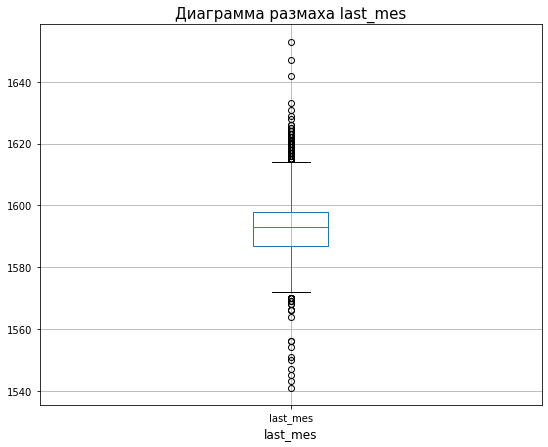

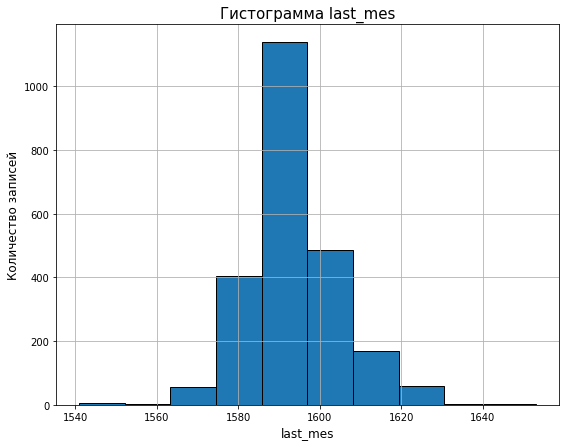

In [76]:
num_feature(data['last_mes'])

Распределение последней измеренной температуры стремиться к нормальному со средним в 1595 градусов.

**Рассмотрим зависимость температуры от потребляемой мощности**

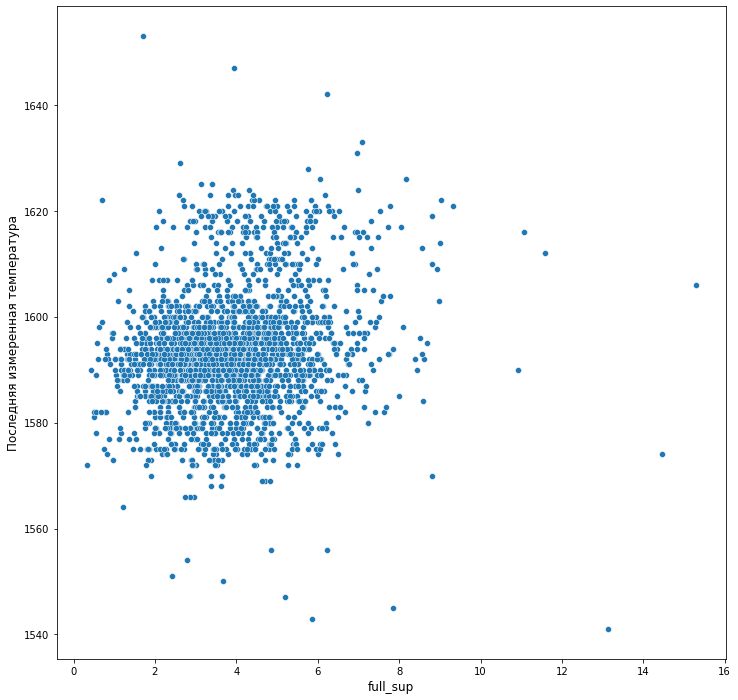

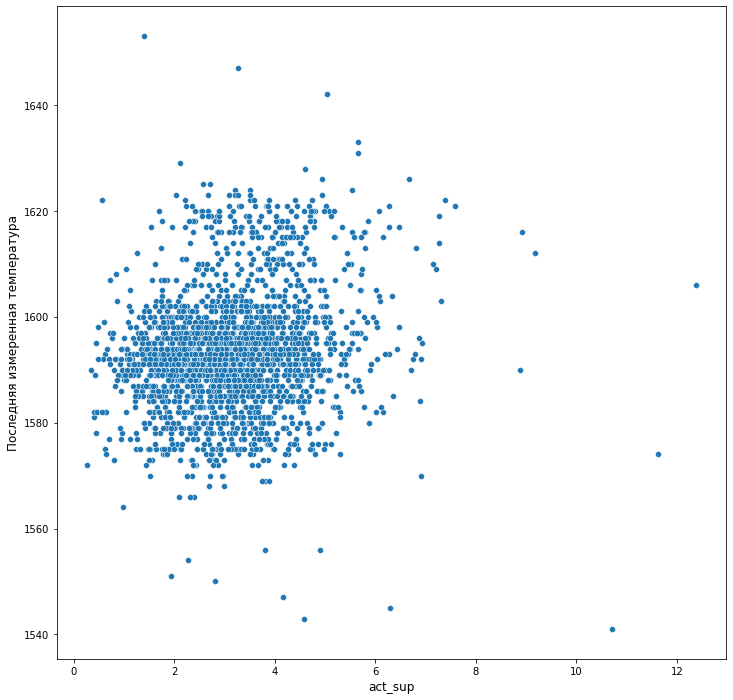

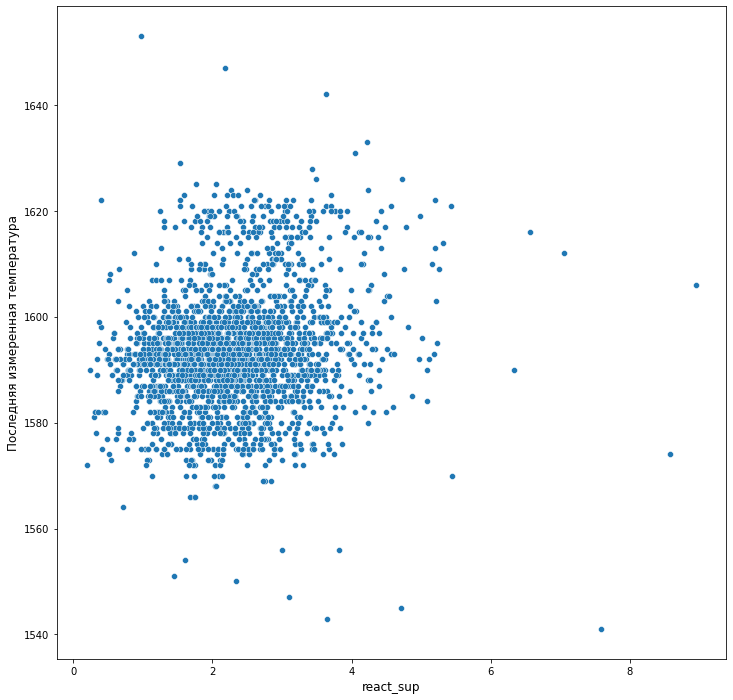

In [77]:
for sup in ['full_sup', 'act_sup', 'react_sup']:
    fig, axs = plt.subplots(figsize=(12, 12))
    sns.scatterplot(data = data, x = sup, y = 'last_mes')
    plt.xlabel(f'{sup}', size = 12)
    plt.ylabel('Последняя измеренная температура', size = 12)
    plt.show()

Четкой прямой зависимости между мощностью и температурой не наблюдается.

Выделим колонки с численными данными

Непопулярные добавки были заменены на категориальные данные: присутствуют/отсутствуют

In [78]:
num_cols = []
for feature in data.columns.tolist():
    if (feature not in unpop_bulk) and  (feature not in unpop_wire):
        num_cols.append(feature)

Проведем анализ корреляции входных признаков и их влияния на таргет, построим матрицу корреляции $\phi_K$

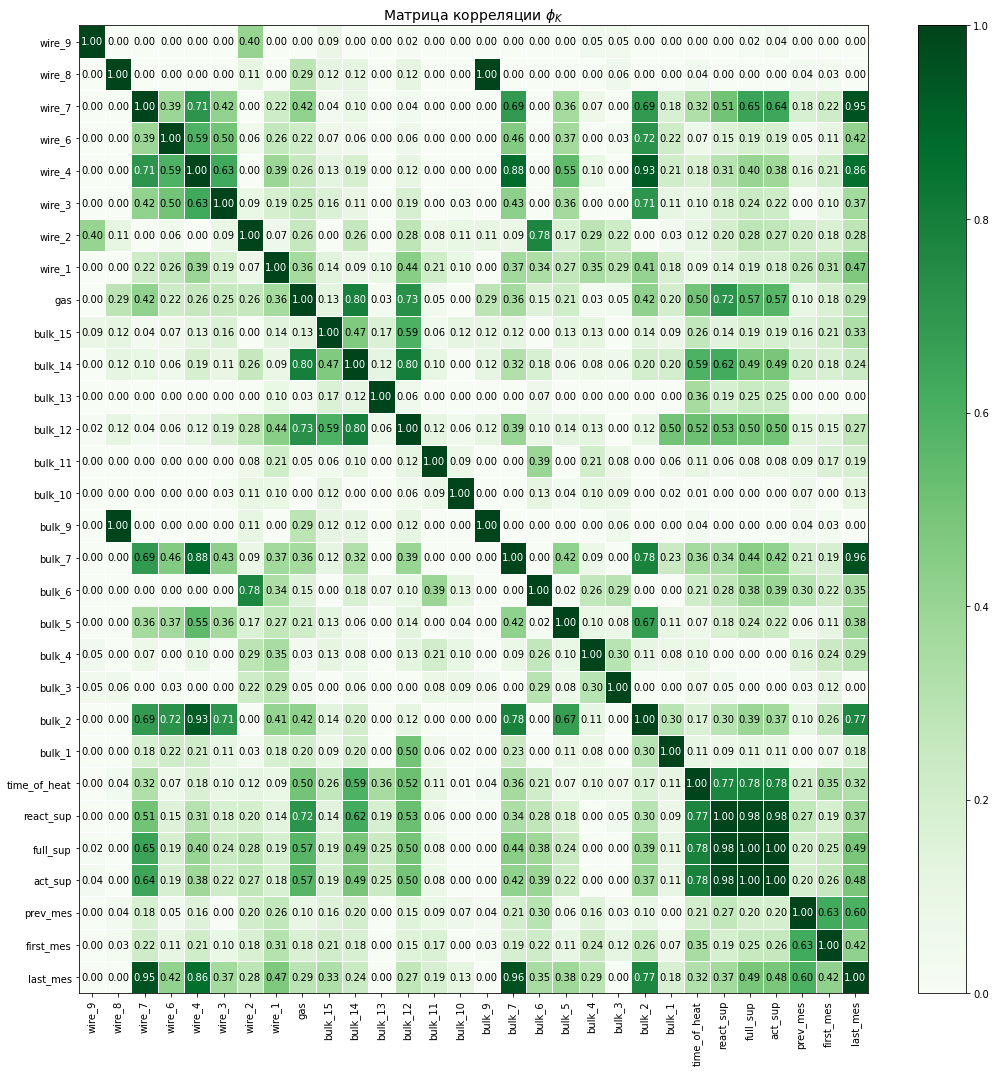

In [79]:
phik_overview = data.phik_matrix(interval_cols=num_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 15))
plt.tight_layout()

Матрица показывает:
1. наличие нескольких высоких значений коэффициента корреляции между различными материалами - вероятнее всего следствие преобладания в датасете популярных марок стали с определенным составом или пары материалов, которые при совместном использовании улучшают физико-технологические свойства сплава;
2. высокие значения коэффициента корреляции между активной, реактивной и полной мощностями - следствие того, что они находятся в прямой зависимости друг от друга;
3. наличие зависимости между последним измерением температуры и матерриалами bulk_2, bulk_7, wire_4, wire_7 - необходимо дополнительно проанализировать наличие зависимости между предсказанием будущей модели температуры сплава и данными материалами.

**Вывод:** 
***1) выполнена необходимая предобработка данных:*** наименование столбцов приведено к змеиному языку, для данных с датой установлен формат datetime, выделены новые признаки: время нагрева, полная мощность;
***2) проведен исследовательский анализ данных каждого датасета отдельно:*** установлены наиболее популярные легирующие элементы, для них проведен анализ попарного содержания в сплаве, выявлена и устранена аномалия в данных по реактивной мощности и температуре;
***3) выполнено объединение датасетов по ключу:*** в соответствии с ТЗ заказчика - модель предсказывает последнюю измеренную температуру сплава: выделен датасет с соответствующими признаками и таргетом;
***4) проведен анализ объединенного датасета:*** устранены пропуски, появившиеся после объединения, проведен анализ корреляции входных признаков и их влияния на таргет.

## Обучение модели

### Разделение на тренировочную и тестовую выборки

In [80]:
X_train,X_test,y_train,y_test = train_test_split(
    data.drop(['last_mes'], axis = 1),
    data['last_mes'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

Исключим из списка числовых колонок таргет

In [81]:
num_cols.remove('last_mes')

### Обучение модели

Для каждой модели необходимо выполнить масштабирование числовых признаков для их лучшего восприятия моделью

Для этого включим в итоговый пайплайн модели препроцессор

In [82]:
preprocessor = ColumnTransformer(
    [
        ('scaler', StandardScaler(), num_cols)
    ], remainder = 'passthrough')

#### AdaBoost

Напишем объектную функцию для подбора гиперпараметров с помощью optuna

In [83]:
def ada_boost_objective(trial):
       
    n_estimators = trial.suggest_int('n_estimators', 25, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 5)
    
    regressor = AdaBoostRegressor(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  random_state = RANDOM_STATE)
    
    final_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    final_pipe.fit(X_train, y_train)
    
    return -cross_val_score(final_pipe,
                           X_train,
                           y_train,
                           scoring = 'neg_mean_absolute_error',
                           cv = 3,
                           n_jobs = -1).mean()

Выполним подбор гиперпараметров

In [84]:
ada_study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

ada_study.optimize(ada_boost_objective, n_trials=25)

[I 2025-08-03 21:39:02,074] A new study created in memory with name: no-name-864fe37d-2fb2-4068-9ad7-6a37be39b1ae
[I 2025-08-03 21:39:05,580] Trial 0 finished with value: 11.089237014701704 and parameters: {'n_estimators': 68, 'learning_rate': 4.096577109781919}. Best is trial 0 with value: 11.089237014701704.
[I 2025-08-03 21:39:09,897] Trial 1 finished with value: 5.45783840132944 and parameters: {'n_estimators': 47, 'learning_rate': 2.8900412567222675}. Best is trial 1 with value: 5.45783840132944.
[I 2025-08-03 21:39:17,778] Trial 2 finished with value: 5.522778421433952 and parameters: {'n_estimators': 83, 'learning_rate': 2.1845805648776344}. Best is trial 1 with value: 5.45783840132944.
[I 2025-08-03 21:39:22,180] Trial 3 finished with value: 8.04215241568379 and parameters: {'n_estimators': 93, 'learning_rate': 3.890711872557541}. Best is trial 1 with value: 5.45783840132944.
[I 2025-08-03 21:39:30,586] Trial 4 finished with value: 5.4596871159176175 and parameters: {'n_estimat

Наименьшая достигнутая MAE:

In [85]:
ada_mae = round(ada_study.best_value,2)
ada_mae

5.22

При этом гиперпараметры модели:

In [86]:
ada_best_params = ada_study.best_params
ada_best_params

{'n_estimators': 64, 'learning_rate': 0.1776028846575466}

#### DecisionTreeRegressor

Напишем объектную функцию для подбора гиперпараметров с помощью optuna

In [87]:
def reg_tree_objective(trial):
       
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 30)
    
    regressor = DecisionTreeRegressor(max_depth = max_depth,
                                      min_samples_split = min_samples_split,
                                      min_samples_leaf = min_samples_leaf,
                                      random_state = RANDOM_STATE)
    
    final_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    final_pipe.fit(X_train, y_train)
    
    return -cross_val_score(final_pipe,
                           X_train,
                           y_train,
                           scoring = 'neg_mean_absolute_error',
                           cv = 3,
                           n_jobs = -1).mean()

Выполним подбор гиперпараметров

In [88]:
tree_study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

tree_study.optimize(reg_tree_objective, n_trials=25)

[I 2025-08-03 21:41:28,982] A new study created in memory with name: no-name-fd9d1819-5a52-433b-8593-00fe08abab68
[I 2025-08-03 21:41:29,476] Trial 0 finished with value: 5.430436554485836 and parameters: {'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 12}. Best is trial 0 with value: 5.430436554485836.
[I 2025-08-03 21:41:29,989] Trial 1 finished with value: 5.333382998595518 and parameters: {'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 16}. Best is trial 1 with value: 5.333382998595518.
[I 2025-08-03 21:41:30,488] Trial 2 finished with value: 5.41797313892834 and parameters: {'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 29}. Best is trial 1 with value: 5.333382998595518.
[I 2025-08-03 21:41:30,901] Trial 3 finished with value: 5.35842882437413 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 28}. Best is trial 1 with value: 5.333382998595518.
[I 2025-08-03 21:41:31,289] Trial 4 finished with value: 5.2868581

Наименьшая достигнутая MAE:

In [89]:
tree_mae = round(tree_study.best_value,2)
tree_mae

5.21

При этом гиперпараметры модели:

In [90]:
tree_best_params = tree_study.best_params
tree_best_params

{'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 18}

#### GradientBoost

Напишем объектную функцию для подбора гиперпараметров с помощью optuna

In [91]:
def lgbm_objective(trial):
    
    X_train_lgbm,X_val,y_train_lgbm,y_val = train_test_split(
    X_train,
    y_train,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)
    
    
    params = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'n_estimators': 10000,
        
        # параметры, которые будем отбирать для GB
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    
    
    model = lgbm.LGBMRegressor(**params)
    model.fit(
        X_train_lgbm, y_train_lgbm,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=100)]  
    )
    
    return -cross_val_score(model,
                           X_train,
                           y_train,
                           scoring = 'neg_mean_absolute_error',
                           cv = 3,
                           n_jobs = -1).mean()

Выполним подбор гиперпараметров

In [ ]:
lgbm_study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

lgbm_study.optimize(lgbm_objective, n_trials=5)

[I 2025-08-03 21:41:41,678] A new study created in memory with name: no-name-4e8f9a18-ef31-42ad-9c8a-47b19dd40c79


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 6.48809	valid_0's l2: 42.0953


Наименьшая достигнутая MAE:

In [ ]:
lgbm_mae = round(lgbm_study.best_value,2)
lgbm_mae

При этом гиперпараметры модели:

In [ ]:
lgbm_best_params = lgbm_study.best_params
lgbm_best_params

### Анализ

Построим таблицу с результатами вычисления средней метрики MAE по результатам кросс-валидации для обученных моделей

In [ ]:
results = pd.DataFrame(data = {'ada': [ada_mae],
                             'tree':[tree_mae],
                              'lgbm': [lgbm_mae]},
                      index = ['mae_cross_val'])
results

Поскольку заказчиком не были озвучены требования по времени обучения и предсказания модели, стоит выбрать наиболее точную, а именно, модель градиентного бустинга

**Вывод:**  
***1. Данные разделены на тренировочную и тестовую выборки***; ***2. Обучены модели регрессии***: наименьшее значение МАЕ по результатам кросс-валидации достигнуто моделью градиентного бустинга МАЕ = 5.12. Гиперпараметры модели: 'learning_rate': 0.22, 'num_leaves': 62,  'max_depth': 4,  'min_child_samples': 9, 'subsample': 0.43, 'colsample_bytree': 0.92.

Поскольку заказчиком не были озвучены требования по времени обучения и предсказания модели, стоит выбрать наиболее точную, а именно, модель градиентного бустинга.

## Тестирование модели и анализ важности признаков

### Тестирование модели

Обучим модель градиентного бустинга

In [ ]:
lgbm_reg = lgbm.LGBMRegressor(objective = 'regression',
                             verbosity = -1,
                             boosting_type = 'gbdt',
                             random_state = RANDOM_STATE,
                             n_estimators = 10000,

                            learning_rate = lgbm_best_params['learning_rate'],
                            num_leaves = lgbm_best_params['num_leaves'],
                            max_depth = lgbm_best_params['max_depth'],
                            min_child_samples = lgbm_best_params['min_child_samples'],
                            subsample = lgbm_best_params['subsample'],
                            colsample_bytree = lgbm_best_params['colsample_bytree'])

In [ ]:
lgbm_reg.fit(X_train, y_train)

Вычислим метрику МАЕ на тестовой выборке

In [ ]:
test_lgbm_mae = round(mean_absolute_error(y_test, lgbm_reg.predict(X_test)), 2)
test_lgbm_mae

Вычислена целевая метрика на тестовой выборке МАЕ = 5.01, что удовлетворяет условию заказчика МАЕ < 6.8.

### Проверка адекватности модели

Проверим наличие необходимости применения сложной модели для предсказывания температуры

In [ ]:
dummy_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DummyRegressor())
    ])

Обучим модель, предсказывающую среднее значение тренировочной выборки

In [ ]:
dummy_pipe.fit(X_train, y_train)

Вычислим целевую выборку с помощью простой модели

In [ ]:
dummy_mae = round(mean_absolute_error(y_test, dummy_pipe.predict(X_test)), 2)
dummy_mae

Вычислим разницу между предсказаниями разных моделей

In [ ]:
test_results = pd.DataFrame(data = {'dummy': [dummy_mae],
                                    'lgbm': [test_lgbm_mae]},
                            index = ['test_mae'])
test_results['diff'] = abs(round((test_results['lgbm']-test_results['dummy']) / test_results['dummy'] * 100,
                            2))
test_results

Исходя из полученных результатов видна необходимость применения сложной модели для предсказывания температуры сплава. Так dummy-алгоритм выполняет предсказания с МАЕ 8.01, что не удовлетворяет критерию заказчика.

### Анализ важности признаков

Построим диаграмму значений Шепли

In [ ]:
explainer = shap.TreeExplainer(lgbm_reg, X_train)
shap_values = explainer(X_train)

In [ ]:
shap.plots.beeswarm(shap_values, max_display = 30)

Построим столбчатую диаграмму вклада признаков в прогноз модели

In [ ]:
shap.plots.bar(shap_values, max_display = 7)

Анализируя построенные графики можем заметить следующее: ***наиболее значимые для модели признаки*** : замер предыдущей температуры, время нагрева, объем подачи материала wire_1, объем подаваемого газа, первый замер температуры, объем подаваемого материала bulk_6. При этом чем выше предыдущая температура замера, больше время нагрева, изначальная температура сплава - тем больше конечная температура сплава, в то время как увеличение продувки газом, содержания bulk_6 говорит о снижении конечной температуры, низкое и высокое содержания материала wire_1 ведет снижению конечной температуры; ***наименее значимые для модели признаки***: наименее популярные в качестве легирования материалы.

Заказчику необходима модель для имитации технологического процесса, а именно контроля температуры сплава с целью снижения энергопотребления. Опираясь на построенные графики значений Шепли можно сказать, что снижение отношения активной мощности к реактивной - приведет к снижению температуры сплава.

В соответствии с разработанной моделью и построенными графиками значений Шепли для поддержания температуры на заданном уровне можно порекомендовать увеличить отношение активной мощности к реактивной за счет модернизации оборудования: увеличение КПД нагревателя, снижение реактивной мощности. Среднее содержание wire_1, снижение продувки газом, меньшее содержание bulk_6, bulk_14, wire_2 способствует увеличению температуры сплава - если сплавы с высоким содержанием этих добавок менее или настолько же рентабельны стоит рассмотреть возможность перепрофилирования производства на изготовление других марок.

**Вывод:** проведено обучение и тестирование модели с гиперпараметрами, подобранными с помощью optuna, целевая метрика на тестовой выборке МАЕ = 5.01 удовлетворяет условию заказчика МАЕ < 6.8, выполнена проверка адеватности модели, установлена необходимость разработки и использования сложной модели для предсказания температуры сплава, выполнен анализ важности признаков, даны рекомендации по снижению энергопотребления.

## Выводы

В настоящей работе было проведено исследование данных металлургического комбината «Стальная птица», разработаны модели для определения конечной температуры сплава, определена наиболее точная.

**Загрузка данных и первичный анализ**, в ходе которых были загружены 7 датасетов с информацией об электродах, о подаче сыпучих материалов, о времени их подачи, о продувке сплава газом, результаты измерения температуры, о подаче проволочных материалах, о времени их подачи, проведен первичный анализ.

**Исследовательский анализ данных**:
1. Анализ датасетов и обработка данных: наименования столбцов датасетов приведены к змеиному языку, для данных с датой установлен формат datetime, выделены новые признаки: время нагрева, полная мощность, выполнен исследовательский анализ числовых данных, зафиксированы пропуски и аномалии.
2. Выполнено объединение датасетов по ключу путем использования сводных таблиц, заполнены пропуски, информация о непопулярных добавках приведена к категорийным данным: присутствуют/отсутствуют.
3. Исследовательский анализ объединенного датасета: устранены пропуски, появившиеся после объединения, проведен анализ влияния мощности на температуру, анализ корреляции входных признаков и их влияния на таргет.

**Обучение ML-моделей**: данные разбиты на тренировочную и тестовую выборки, с помощью инструмента поиска гиперпараметров optuna найдена модель, имеющая наименьшее значение метрики МАЕ по результатам кросс-валидации. Лучшая модель `LGBMRegressor(colsample_bytree=0.9470930118135502, learning_rate=0.2726519349243251, max_depth=10, min_child_samples=15, n_estimators=10000, num_leaves=79, objective='regression', random_state=280725, subsample=0.5447928175250335, verbosity=-1)`. Значение метрики по результатам кросс-валидации равно 5.12, что является высоким показателем качества решения. Поскольку заказчиком не были озвучены требования по времени обучения и предсказания модели, для тестирования выбрана наиболее точная модель.

**Тестирование модели и анализ важности признаков**:
1. Тестирование: проведено обучение и тестирование модели с гиперпараметрами, подобранными с помощью optuna, целевая метрика на тестовой выборке МАЕ = 5.01 удовлетворяет условию заказчика МАЕ < 6.8, выполнена проверка адеватности модели, установлена необходимость разработки и использования сложной модели для предсказания температуры сплава;
2. Анализ важности признаков: ***наиболее значимые для модели признаки*** : замер предыдущей температуры, время нагрева, объем подачи материала wire_1, объем подаваемого газа, первый замер температуры, объем подаваемого материала bulk_6. При этом чем выше предыдущая температура замера, больше время нагрева, изначальная температура сплава - тем больше конечная температура сплава, в то время как увеличение продувки газом, содержания bulk_6 говорит о снижении конечной температуры, низкое и высокое содержания материала wire_1 ведет снижению конечной температуры; ***наименее значимые для модели признаки***: наименее популярные в качестве легирования материалы.

**Разработаны рекомендации:** в соответствии с разработанной моделью и построенными графиками значений Шепли для поддержания температуры на заданном уровне можно порекомендовать увеличить отношение активной мощности к реактивной за счет модернизации оборудования: увеличение КПД нагревателя, снижение реактивной мощности. Среднее содержание wire_1, снижение продувки газом, меньшее содержание bulk_6, bulk_14, wire_2 способствует увеличению температуры сплава - если сплавы с высоким содержанием этих добавок менее или настолько же рентабельны стоит рассмотреть возможность перепрофилирования производства на производство других марок.